In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch
from scipy.signal import convolve

In [2]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [3]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CSG/'

# Prepare Data

In [4]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8']
ncols = (len(regions) + 1) // 2 # plotting
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/clear_sky_generation/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds = xr.Dataset(region_darrays)
ds = ds.load()
# Assign Brisbane time
time_utc = pd.to_datetime(ds.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds = ds.assign_coords(time=("time", time_aest_naive))

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


### Remove the 3 bad days

In [5]:
bad_days = [
    np.datetime64('2019-08-12'),
    np.datetime64('2019-10-01'),
    np.datetime64('2020-09-06'),
    
]
ds_dates = ds['time'].dt.floor('D')
good_time_mask = ~ds_dates.isin(bad_days)
ds = ds.sel(time=ds['time'][good_time_mask])

### Assign "time of year" coordinate for bias correction

In [6]:
ds = ds.assign_coords(
        time_of_year=ds['time'].dt.strftime("%m-%d")
    )

### Remove dusk and dawn data

In [7]:
# REMOVE BAD DUSK AND DAWN DATA
for reg in regions:
    ds[reg] = solar_plotting.clip_dusk_dawn(ds[reg], n=6)

# Bias Correction

In [8]:
# Only look at the middle hours when finding biases
mask = (ds['time'].dt.hour > 10) & (ds['time'].dt.hour < 15)

In [9]:
def get_bias(da):
    # prevent actual cloudy data from bringing down mean
    da = da.clip(min=0.95)
    da_biases = da.rolling(time_of_year=30, center=True, min_periods=1).max()
    da_biases_smooth = da_biases.rolling(time_of_year=100, center=True, min_periods=1).mean()
    return da_biases_smooth

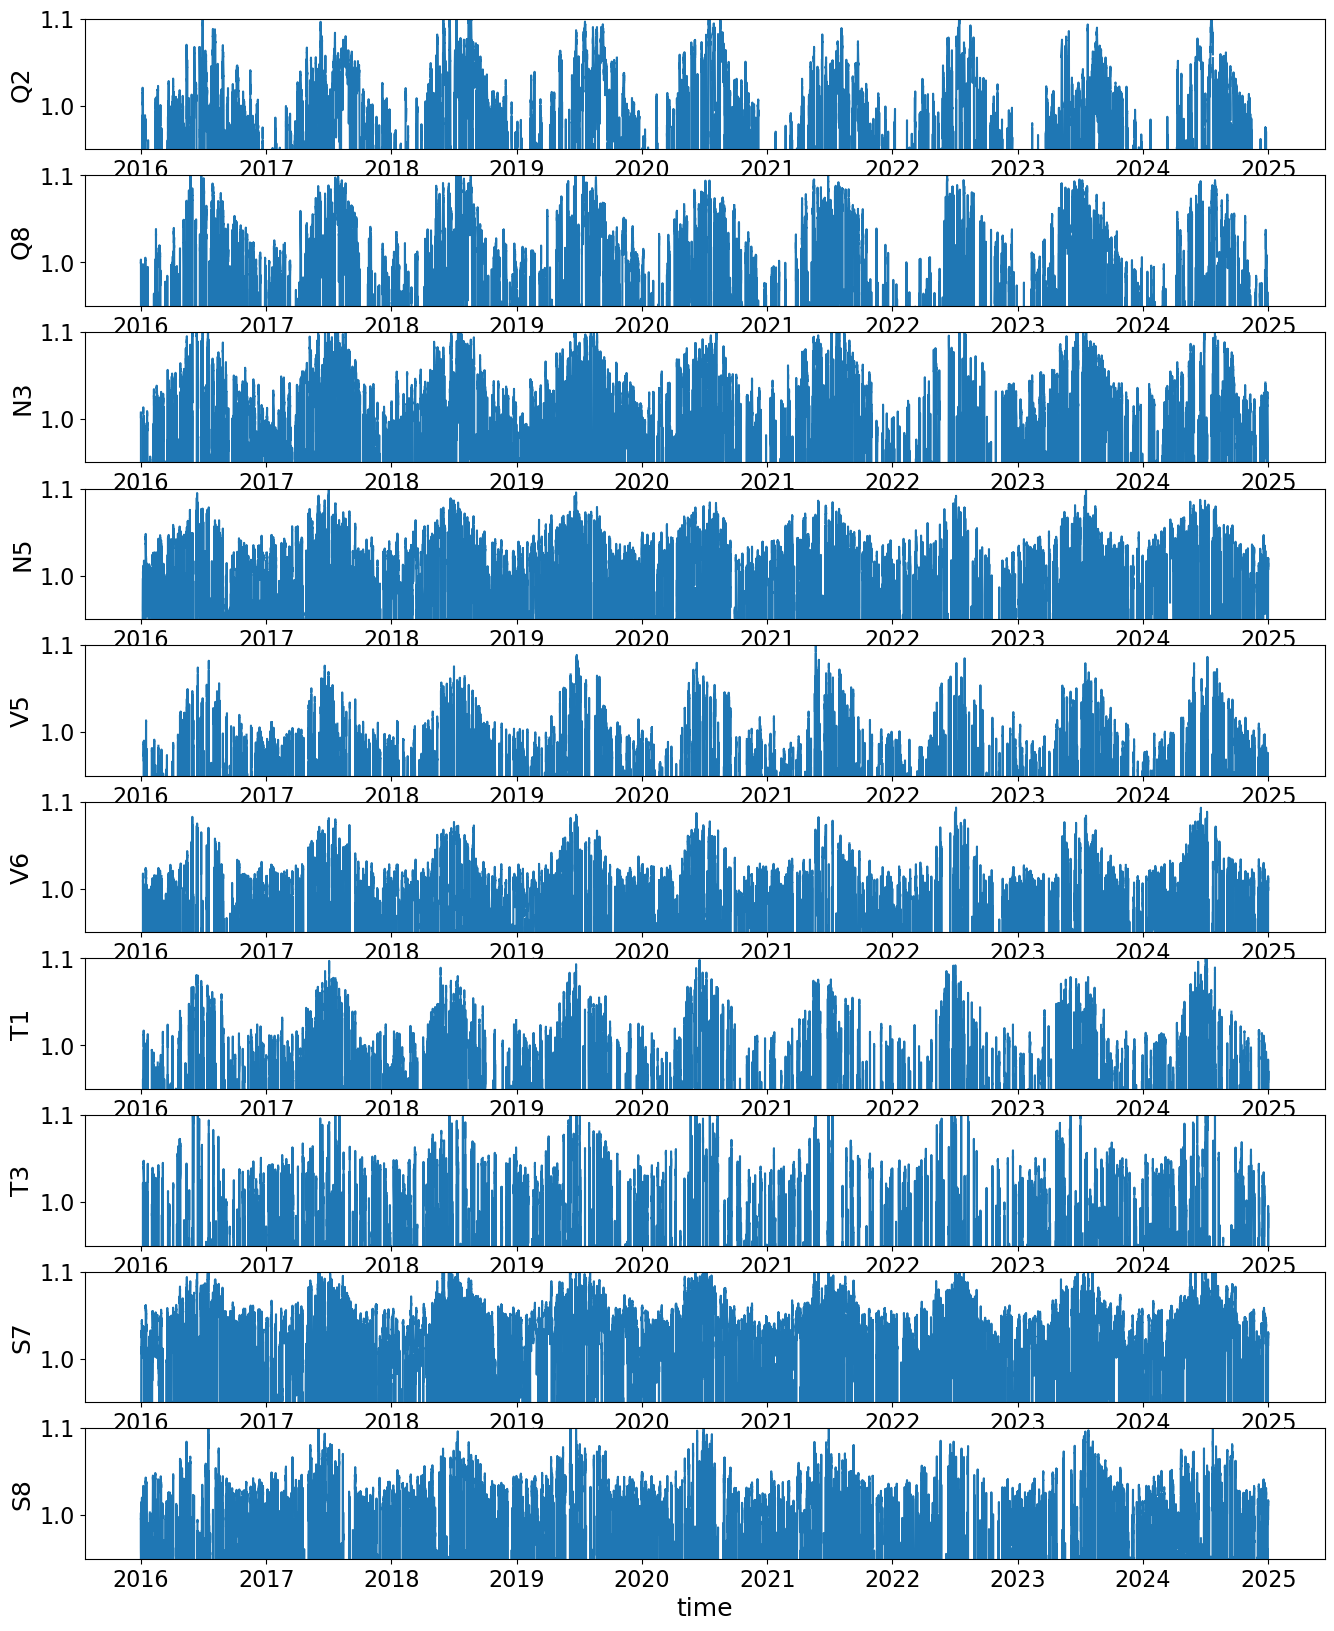

In [10]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ds[reg][mask].plot(ax=ax[i])
    ax[i].set_ylim(0.95, 1.1)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

<Axes: >

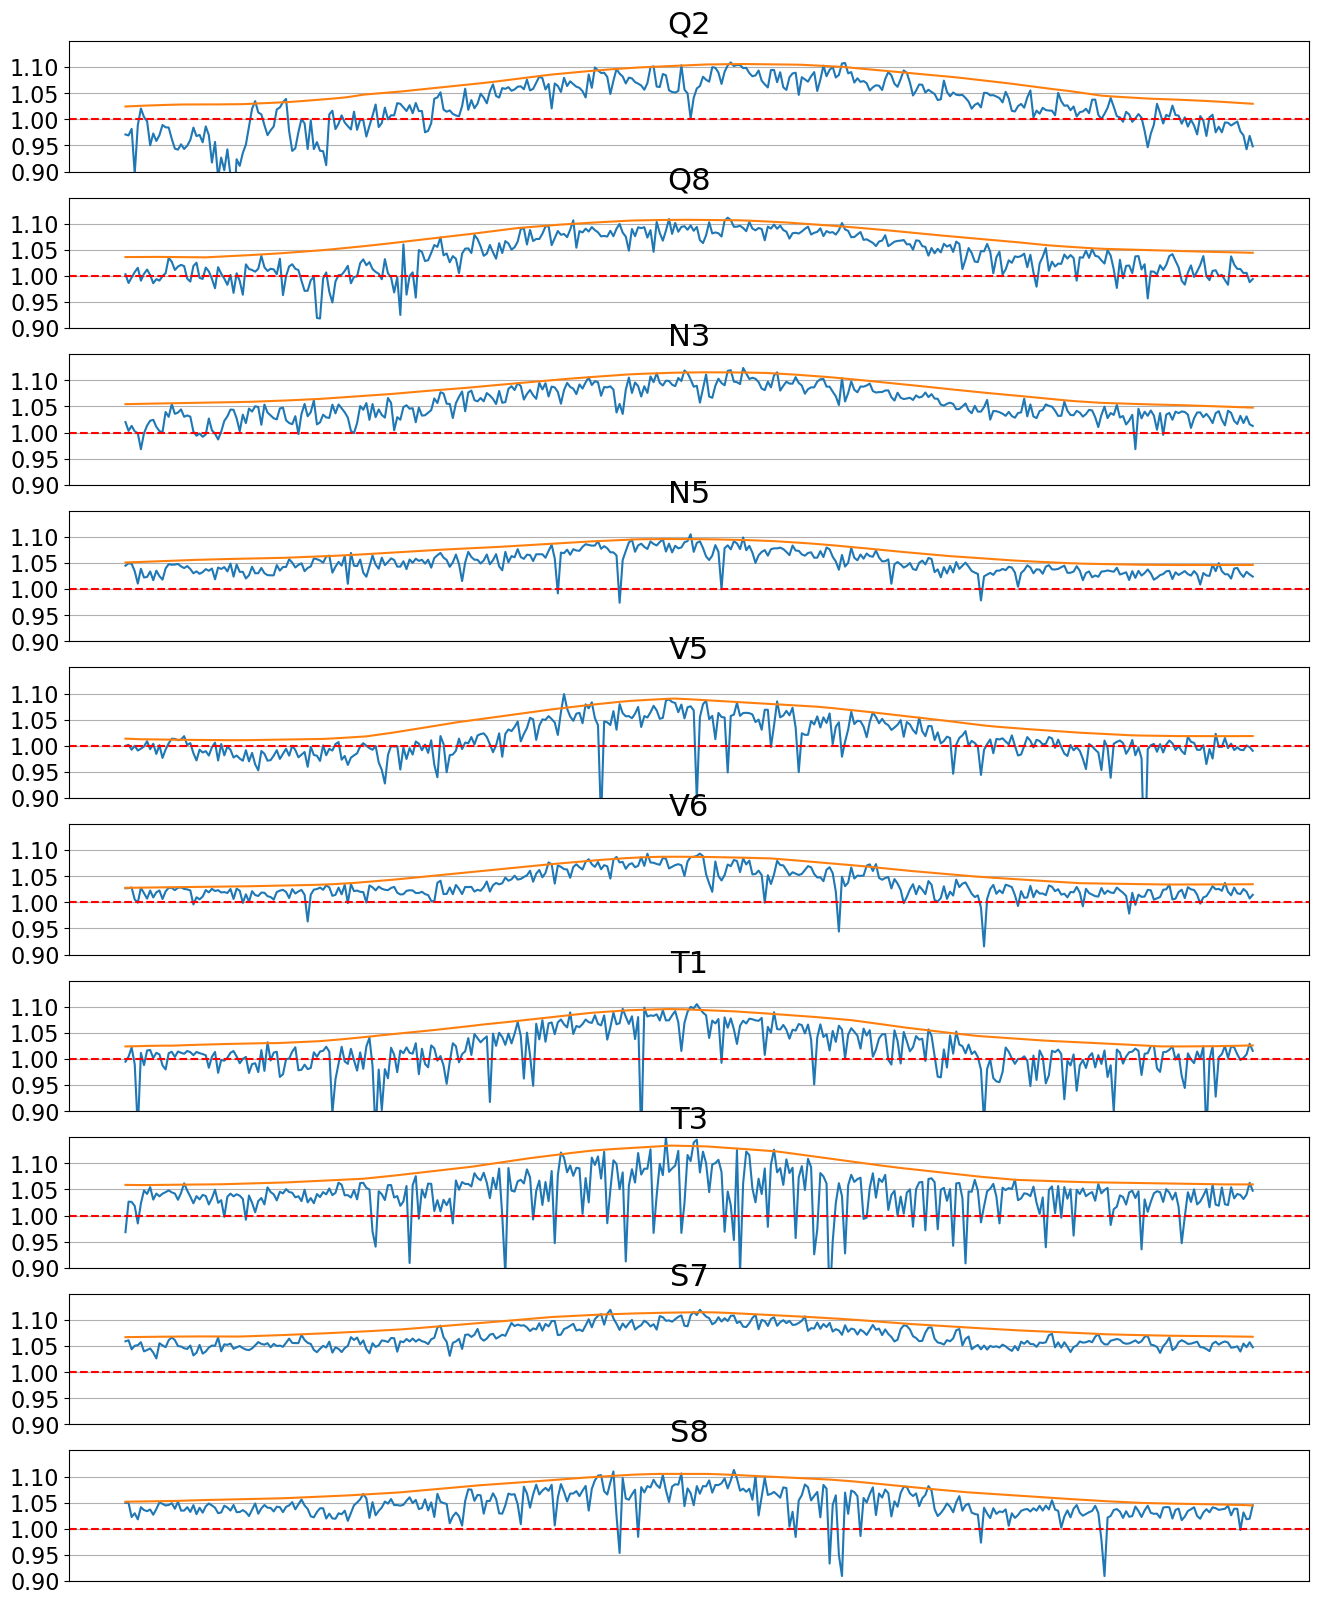

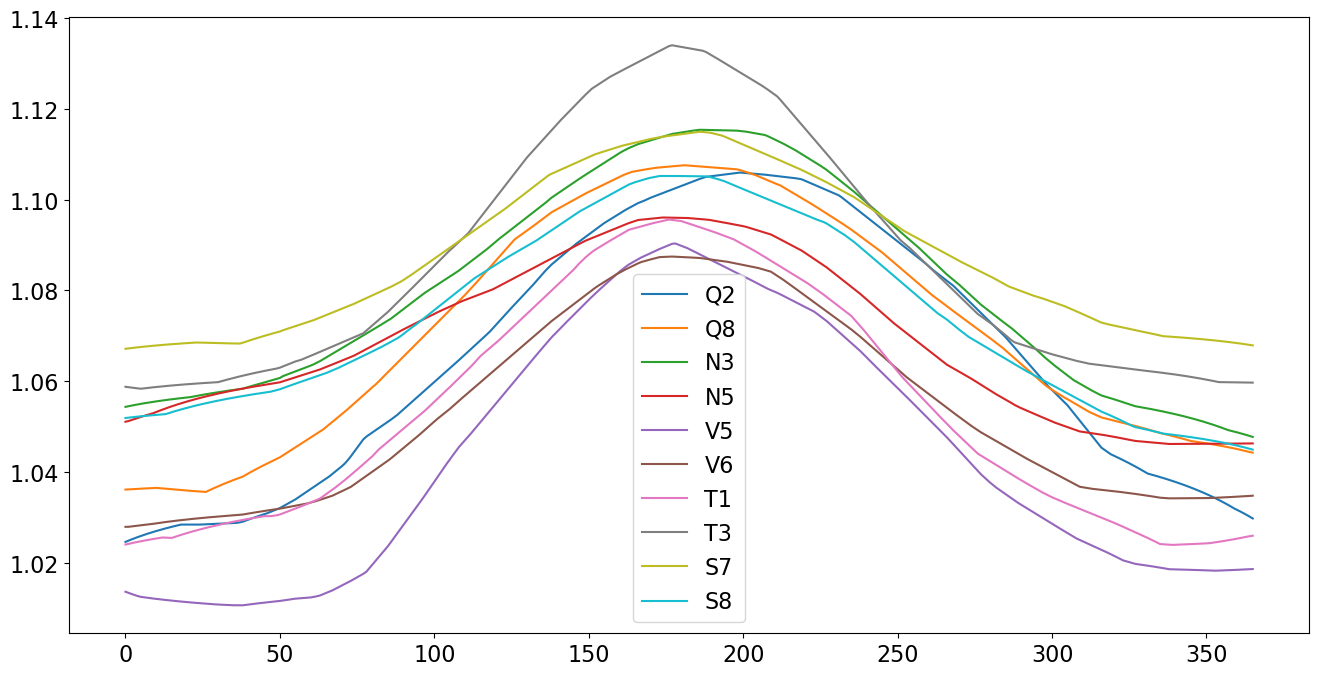

In [11]:
bias = {}
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    ax[i].plot(ds[reg][mask].groupby('time_of_year').max().values)
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ax[i].plot(reg_bias.values)
    bias[reg] = reg_bias.values
    ax[i].set_ylim(0.9, 1.15)
    ax[i].set_yticks([1])
    ax[i].axhline(1, color='r', linestyle='--')
    ax[i].set_yticks(np.linspace(0.9, 1.1, 5))
    ax[i].set_xticks([])
    ax[i].set_title(reg)
    ax[i].grid(True)
bias_df = pd.DataFrame(
    bias,
    # index=ds_aus.resample(time='1D').max().time
)
bias_df.plot(figsize=(16,8))

# Bias Correction

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

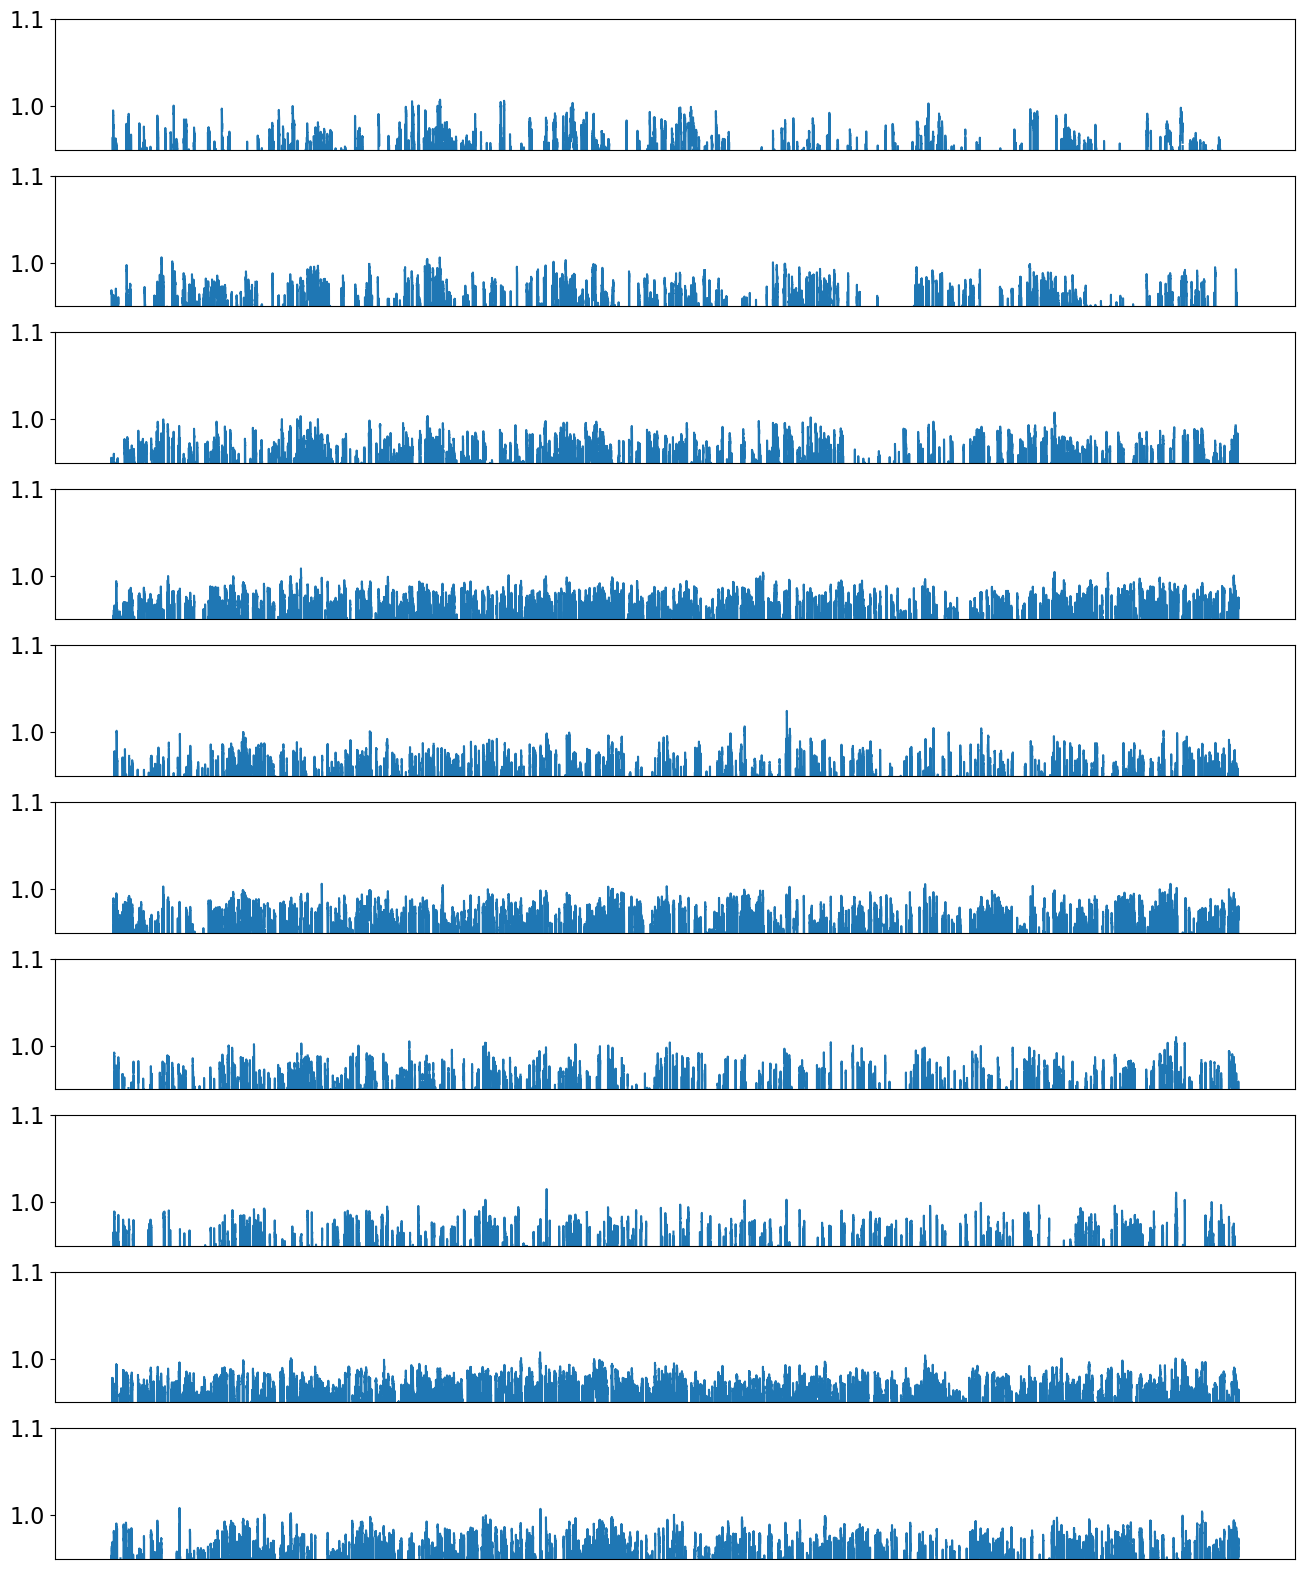

In [12]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(16, 20))
for i, reg in enumerate(regions):
    reg_bias = get_bias(ds[reg][mask].groupby('time_of_year').max())
    ds[reg] = ds[reg].groupby('time_of_year') / reg_bias
    ax[i].plot(ds[reg][mask])
    ax[i].set_xticks([])
    ax[i].set_ylim(0.95, 1.1)

### Clip remaining values above 1

In [13]:
ds = ds.clip(max=1)

# Remove missing middle of the day time

In [14]:
ds = ds.where(ds['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Make a combined "total" variable to represent all regions

In [15]:
stacked = xr.concat([ds[var] for var in ds.data_vars], dim="region")

total = stacked.mean(dim="region")

ds["total"] = total

# Constant below threshold

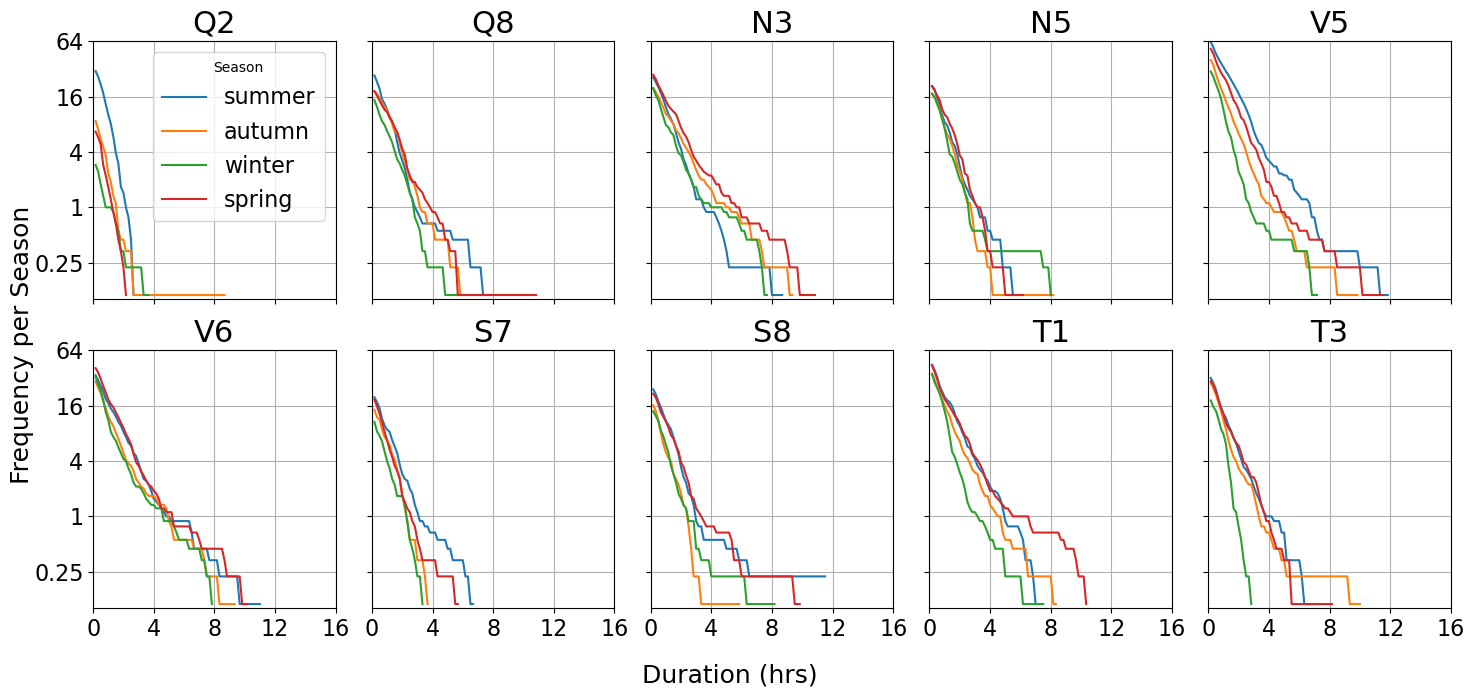

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.constant_below_threshold(da=ds_aus[reg], threshold=0.2)
    for season in cbt:
        x = np.array(cbt[season][0])
        y = np.array(cbt[season][1])
        ax[i].plot(x[y > 0], y[y > 0], label=season)
    ax[i].set_title(reg)
    ax[i].grid(True)

    # Set log scale and custom tick formatting for y-axis
    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax[0].legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

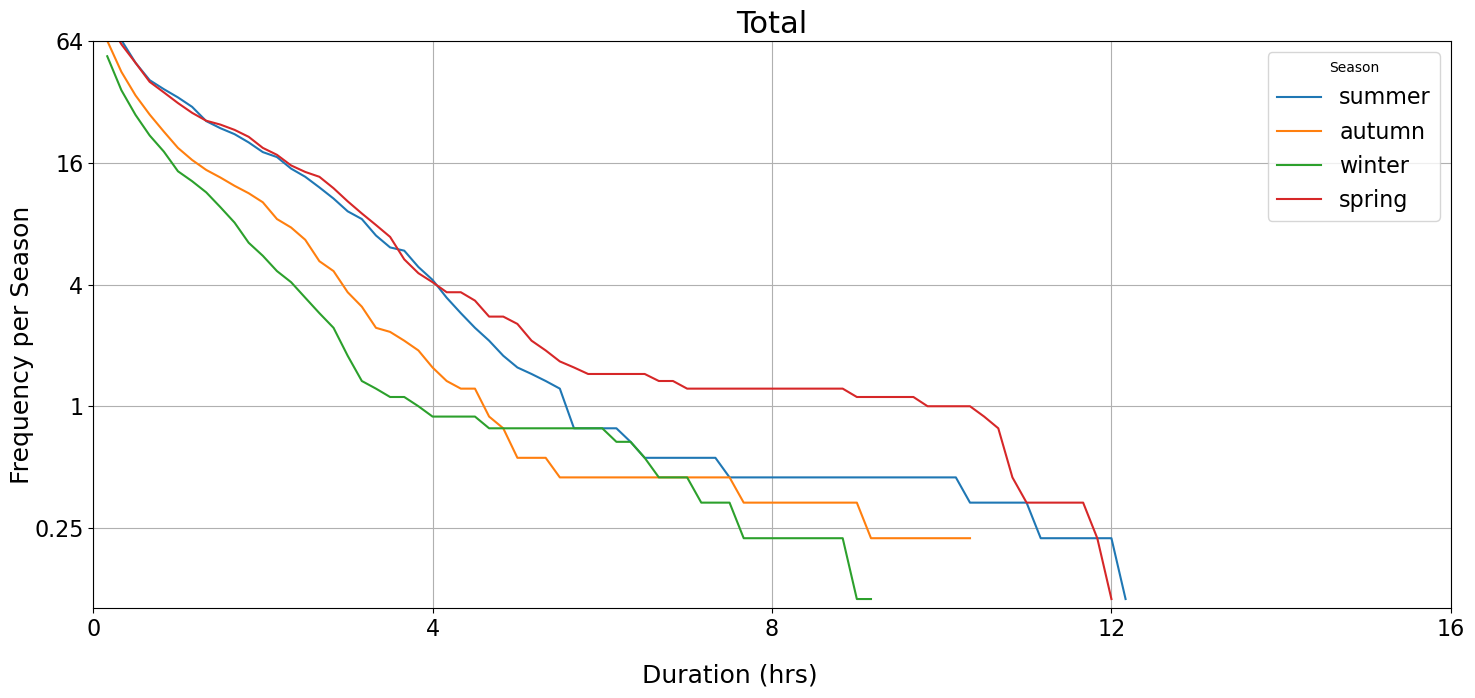

In [9]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True, sharey=True)


cbt = solar_plotting.constant_below_threshold(da=ds_aus.total, threshold=0.5)
for season in cbt:
    x = np.array(cbt[season][0])
    y = np.array(cbt[season][1])
    ax.plot(x[y > 0], y[y > 0], label=season)
ax.set_title("Total")
ax.grid(True)

# Set log scale and custom tick formatting for y-axis
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax.legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()

plt.show()

# Mean Below Threshold

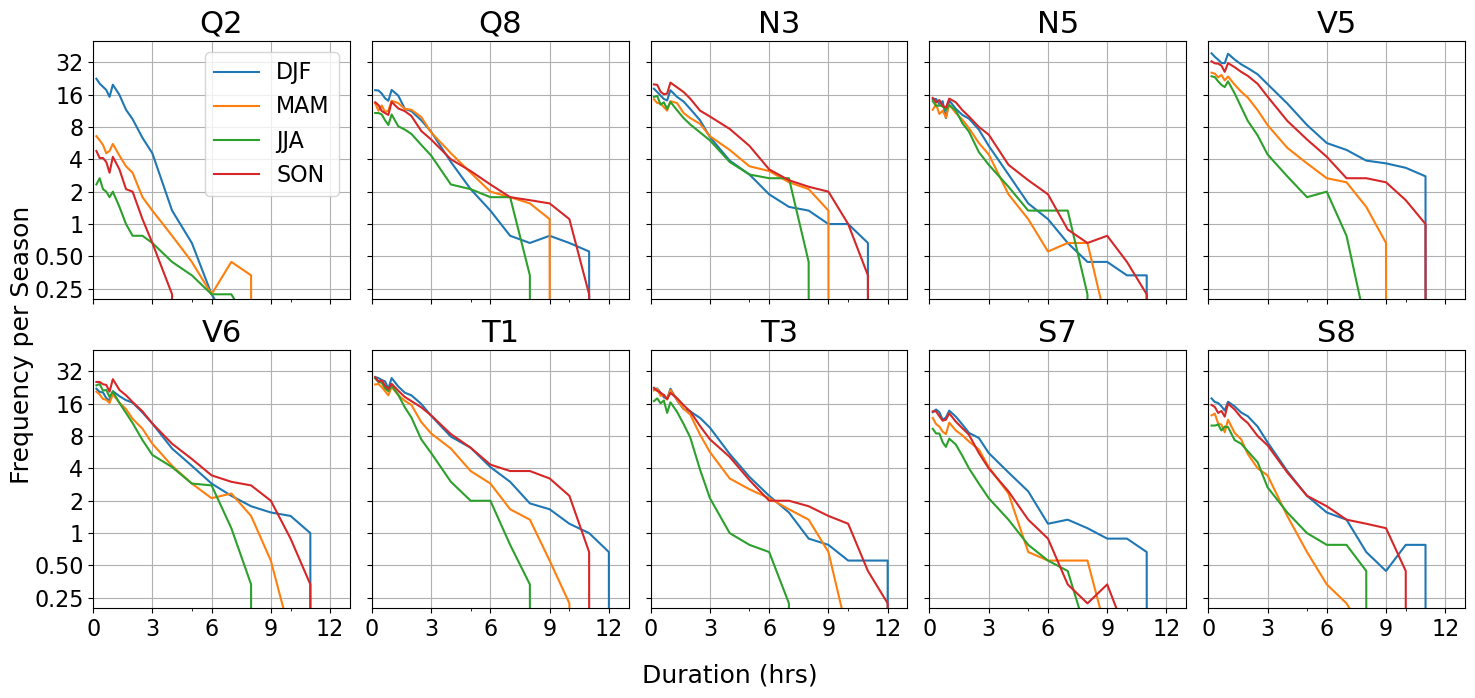

In [69]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

drought_lengths = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78]

for i, reg in enumerate(regions):
    mbt = solar_plotting.mean_below_threshold(da=ds[reg], threshold=0.2, drought_lengths=drought_lengths)
    mbt.plot(ax=ax[i])
    ax[i].set_title(reg, rotation=0)
    ax[i].set_xlabel('')
    ax[i].legend().remove()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()

fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,13)
plt.xticks(range(0,13, 3))
plt.ylim(0.2,50)
plt.yticks([0.25, 0.5, 1, 2, 4, 8, 16, 32])
plt.tight_layout()
plt.show()

In [59]:
sorted(np.linspace(6,72,12), reverse=True)

[72.0, 66.0, 60.0, 54.0, 48.0, 42.0, 36.0, 30.0, 24.0, 18.0, 12.0, 6.0]

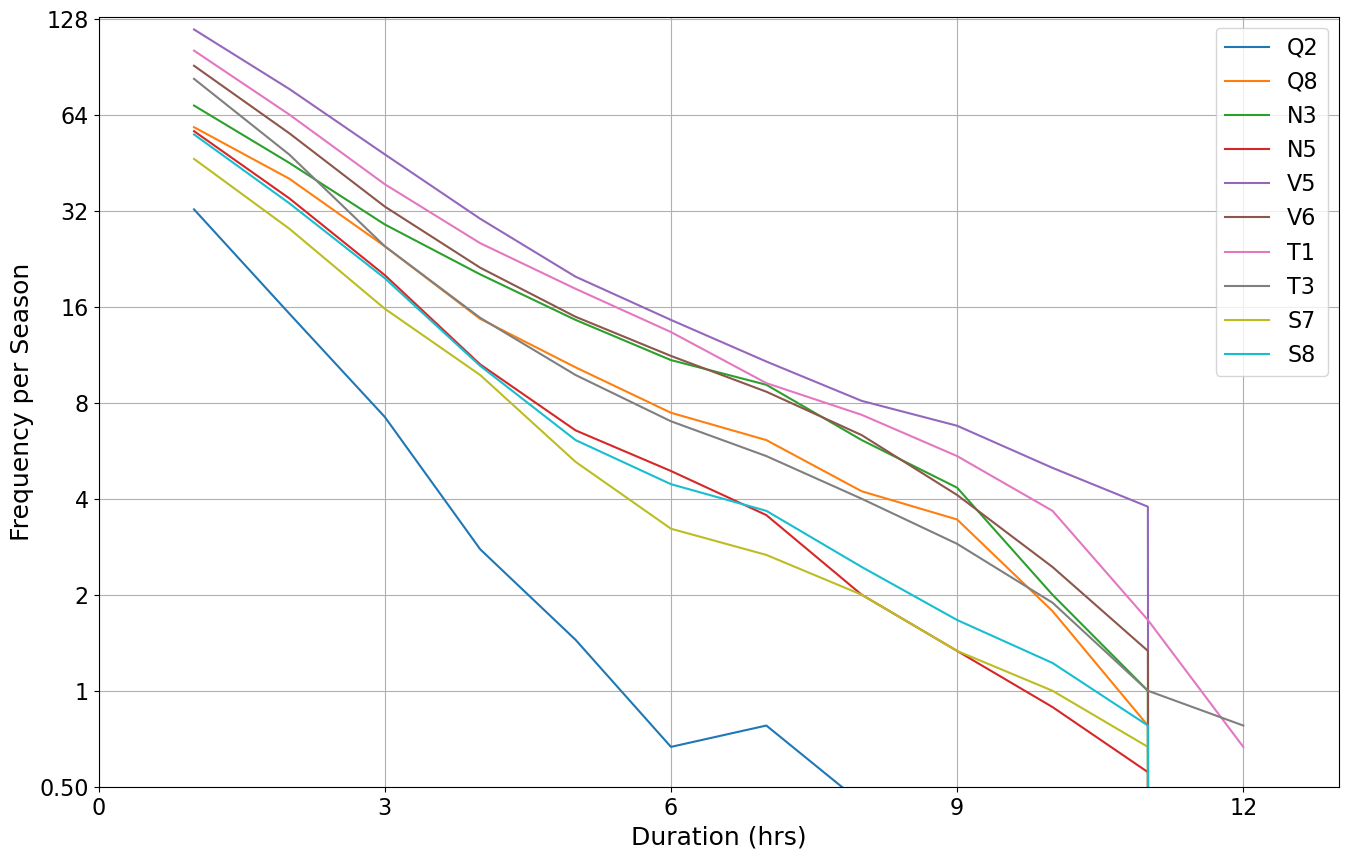

In [61]:
def mean_below_threshold(da, threshold, drought_lengths):
    drought_lengths = sorted(drought_lengths, reverse=True)

    n_droughts = []
    
    n_years = len(np.unique(da.time.dt.year))
    counted_droughts = xr.zeros_like(da, dtype=bool)
    for time in drought_lengths:
        time = int(time)
    
        rolling_mean = da.rolling(time=time, center=False).mean()
        droughts = xr.where(rolling_mean < threshold, 1, 0)
        # only count droughts not counted in a longer period
        new_droughts = droughts & (~counted_droughts)
        # ensure droughts lasting longer than the given window are not counted multiple times
        shifted = new_droughts.shift(time=1, fill_value=0)
        drought_starts = xr.where((new_droughts == 1) & (shifted == 0), 1, 0)

        n_droughts.append(drought_starts.sum().item() / n_years)

        counted_droughts = counted_droughts | new_droughts

    return n_droughts
drought_lengths = np.linspace(6, 72, 12)
fig, ax = plt.subplots(figsize=(16,10))
for reg in regions:
    mbt_droughts = mean_below_threshold(ds[reg], 0.2, drought_lengths)
    x_data = np.divide(sorted(drought_lengths, reverse=True), 6)
    ax.plot(x_data, mbt_droughts, label=reg)


ax.grid(True)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


plt.xlabel('Duration (hrs)', fontsize=18)
plt.ylabel('Frequency per Season', fontsize=18)
plt.xlim(0,13)
plt.xticks(range(0,13, 3))
plt.ylim(0.5,130)
# plt.yticks([0.25, 0.5, 1, 2, 4, 8, 16, 32])

ax.legend()

# Multi-Day Droughts

/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 v

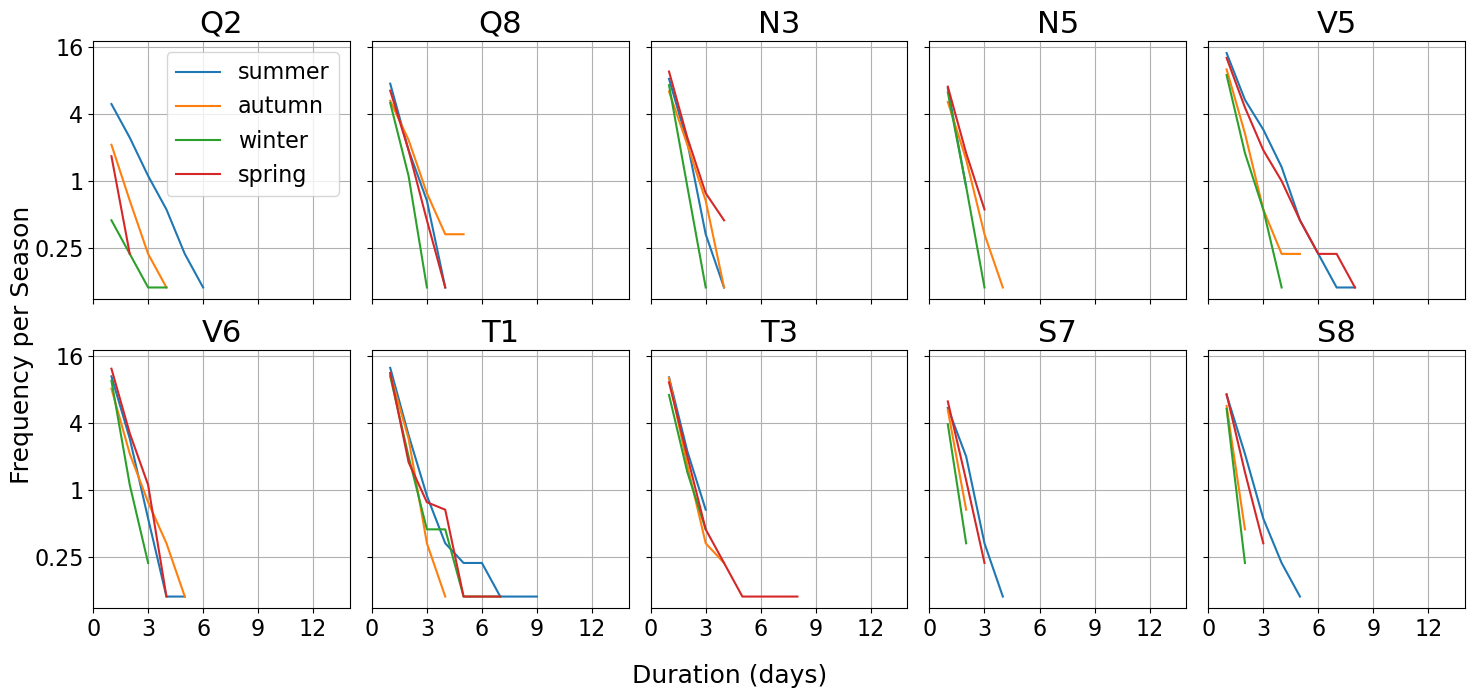

In [42]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.daily_drought(
        da=ds[reg], 
        threshold = 0.2,
        tot_time=12,
        max_len=6,
        day_mean=0.2,
    )
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(reg)
    ax[0].legend()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()

fig.supxlabel('Duration (days)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,14)
plt.xticks(range(0, 14, 3))
plt.tight_layout()
plt.show()

# Day/time Heatmap

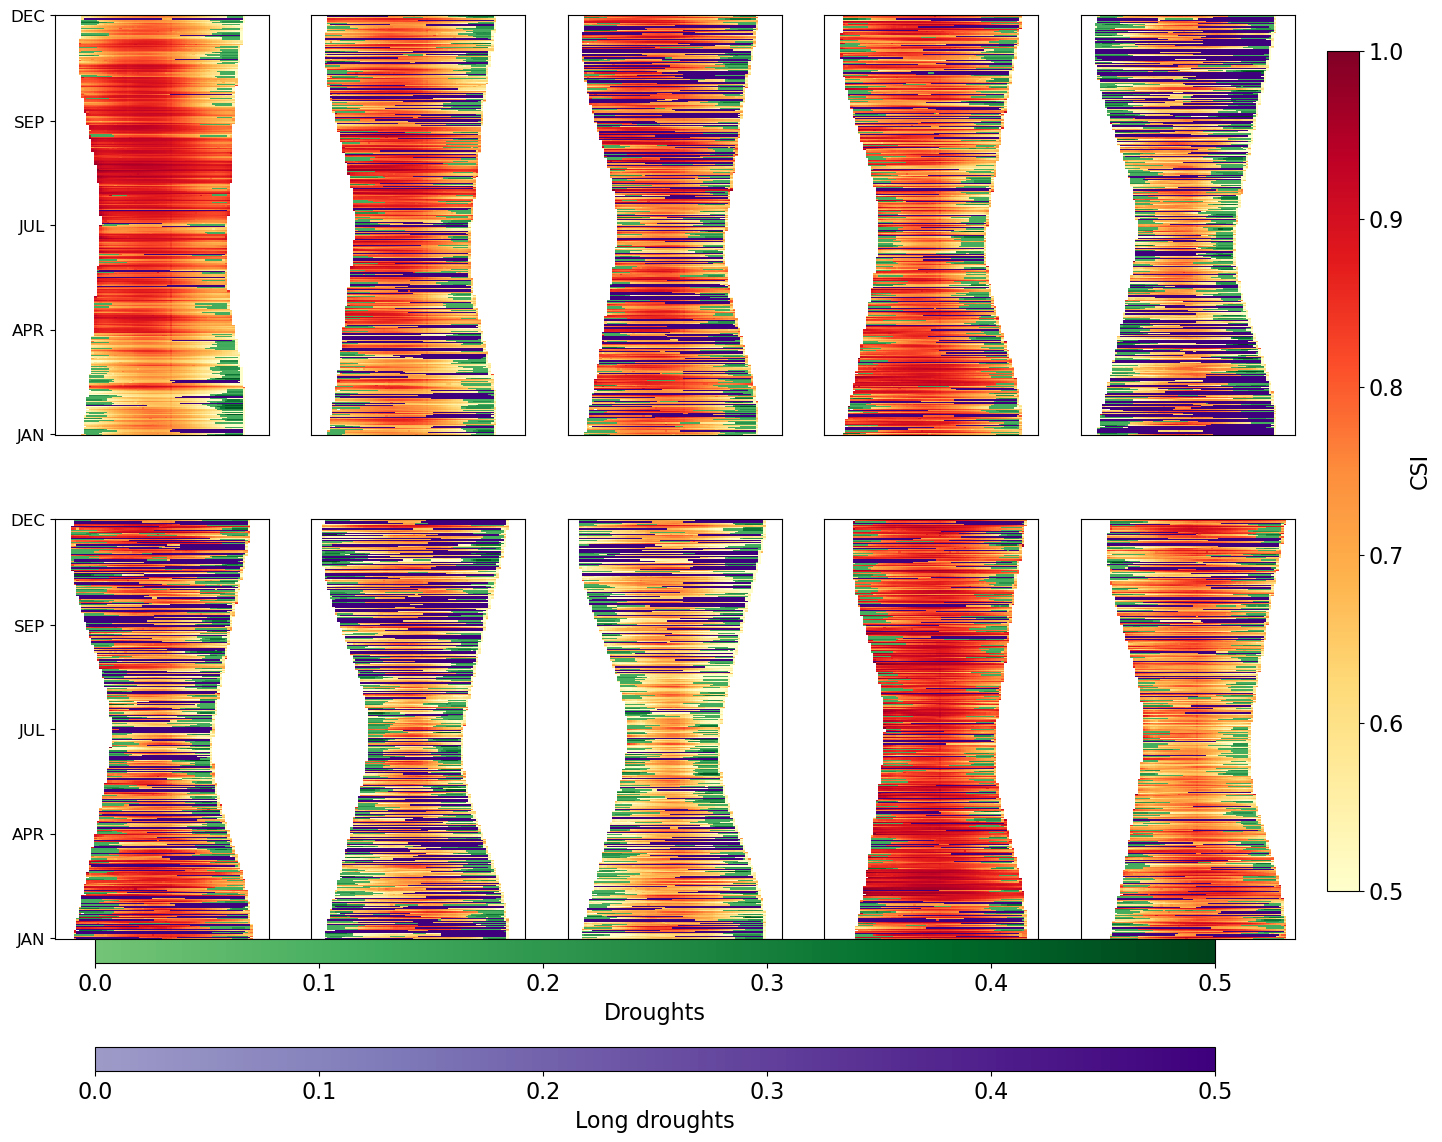

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(16, 12))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02])
cbar_droughts_long_ax = fig.add_axes([0.15, 0.00, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd
cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
    'Greens_top_half', plt.cm.Greens(np.linspace(0.5, 1.0, 256))
)
cmap_droughts_long = mcolors.LinearSegmentedColormap.from_list(
    'Purples_top_half', plt.cm.Purples(np.linspace(0.5, 1.0, 256))
)
cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')
cmap_droughts_long.set_bad(color='none')
im = None
im_droughts = None
im_droughts_long = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    df = solar_plotting.day_time_df(ds[reg])
    df = df.drop(df.columns[49], axis=1)

    # short droughts
    df_droughts = solar_plotting.day_time_mbt(ds[reg], threshold = 0.2, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)

    # long droughts
    df_droughts_long = solar_plotting.day_time_mbt(ds[reg], threshold = 0.2, drought_length=4)
    df_droughts_long = df_droughts_long.drop(df_droughts.columns[49], axis=1)
    df_droughts_long[df_droughts_long == 0] = np.nan
    df_droughts_long[~df_droughts_long.isna()] = 1
    df_droughts_long = df_droughts_long.drop(df_droughts_long.columns[49], axis=1)
    # alpha_long = np.where(np.isnan(df_droughts_long), 0, 1)

    im = ax[row, col].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax[row, col].imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0, vmax=0.5, interpolation='none', zorder=1)
    im_droughts_long = ax[row, col].imshow(df_droughts_long, aspect="auto", origin="lower", cmap=cmap_droughts_long, vmin=0, vmax=0.5, interpolation='none', zorder=2)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax[row, col].set_xticks(xticks)
    ax[row, col].set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax[row, col].set_yticks(yticks)
        ax[row, col].set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax[row, col].set_yticks([])
    ax[row, col].set_xticks([])

    ax[row, col].set_xlim(4,89)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('Droughts', fontsize=16)
fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal').set_label('Long droughts', fontsize=16)

fig_path = f'{fig_dir}/heatmap'
os.makedirs(fig_path, exist_ok=True)
# plt.savefig(f'{fig_path}/CSG-day-time-avail.png')
plt.show()

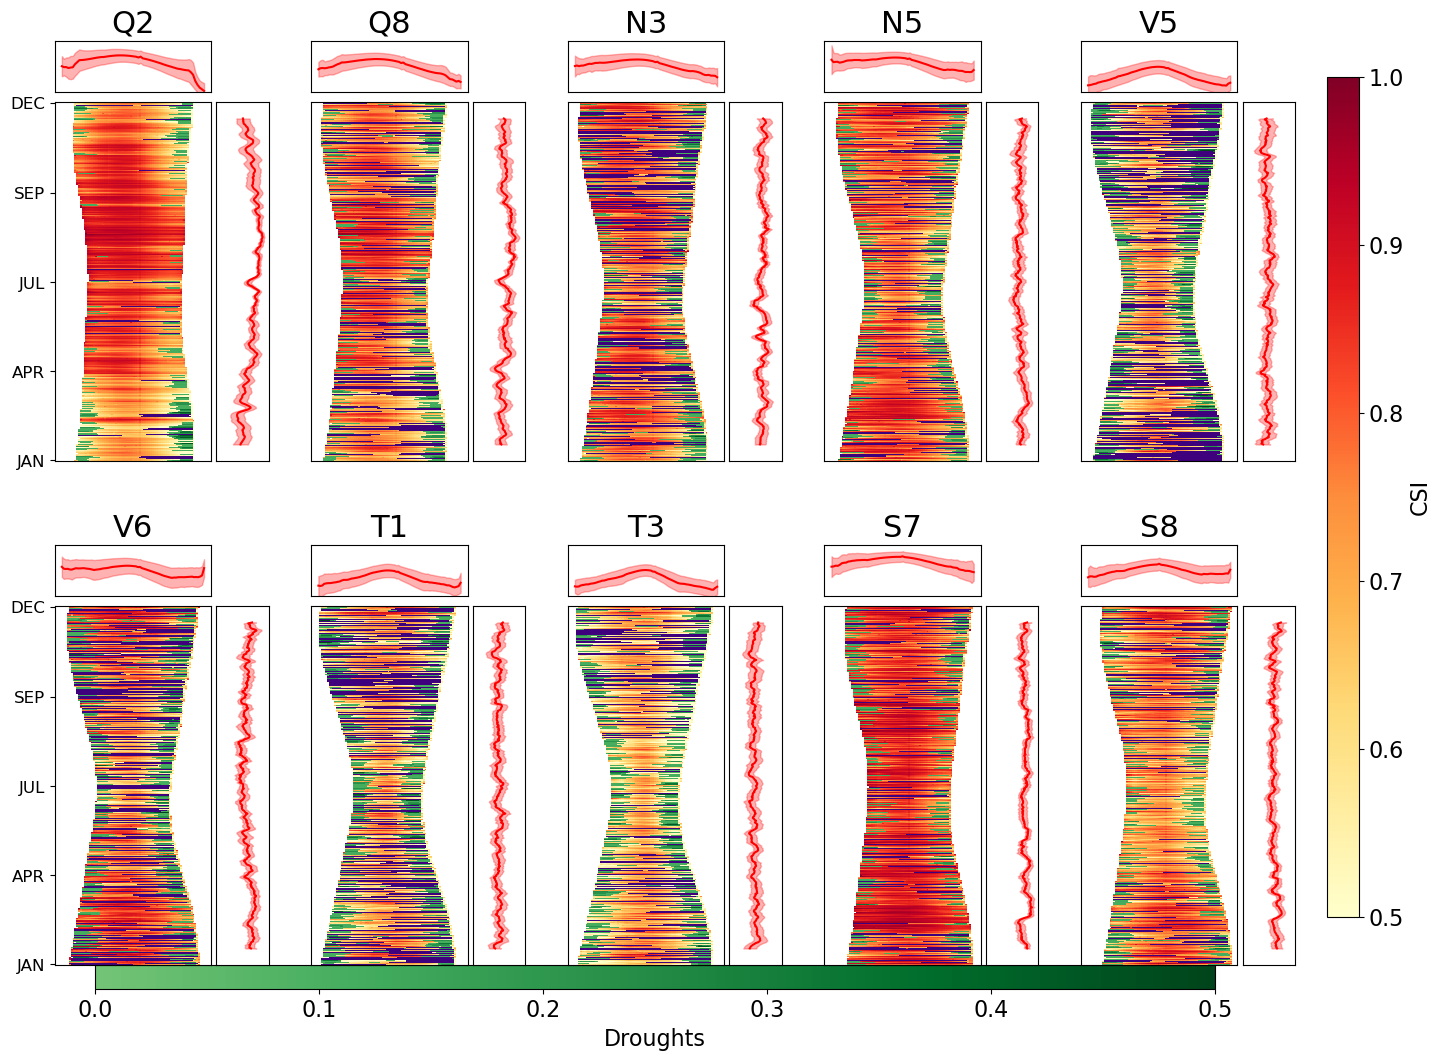

In [18]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02])
# cbar_droughts_long_ax = fig.add_axes([0.15, 0.00, 0.7, 0.02])

# Create the colormaps
cmap = plt.cm.YlOrRd
cmap_droughts = mcolors.LinearSegmentedColormap.from_list(
    'Greens_top_half', plt.cm.Greens(np.linspace(0.5, 1.0, 256))
)
cmap_droughts_long = mcolors.LinearSegmentedColormap.from_list(
    'Purples_top_half', plt.cm.Purples(np.linspace(0.5, 1.0, 256))
)
cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')
cmap_droughts_long.set_bad(color='none')
im = None
im_droughts = None
im_droughts_long = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0])#, sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1])#, sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_df(ds[reg])
    df = df.drop(df.columns[49], axis=1)

    # short droughts

    df_droughts = solar_plotting.day_time_mbt(ds[reg], threshold = 0.2, drought_length=1)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    
    # # set upper limit the length of droughts
    # df_droughts_upper = day_time_mbt(ds[reg], threshold = 0.2, drought_length=2)
    # mask = (~df_droughts.isna()) & (~df_droughts_upper.isna())
    # df_droughts[mask.astype(bool)] = np.nan

    # long droughts
    df_droughts_long = solar_plotting.day_time_mbt(ds[reg], threshold = 0.2, drought_length=4)
    df_droughts_long = df_droughts_long.drop(df_droughts.columns[49], axis=1)
    df_droughts_long[df_droughts_long == 0] = np.nan
    df_droughts_long[~df_droughts_long.isna()] = 1
    df_droughts_long = df_droughts_long.drop(df_droughts_long.columns[49], axis=1)
    # alpha_long = np.where(np.isnan(df_droughts_long), 0, 1)

    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0.5, vmax=1, interpolation='none', zorder=0)
    im_droughts = ax_heatmap.imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0, vmax=0.5, interpolation='none', zorder=1)
    im_droughts_long = ax_heatmap.imshow(df_droughts_long, aspect="auto", origin="lower", cmap=cmap_droughts_long, vmin=0, vmax=0.5, interpolation='none', zorder=2)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax_heatmap.set_yticks(yticks)
        ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax_heatmap.set_yticks([])
    ax_heatmap.set_xticks([])

    ax_heatmap.set_xlim(4,89)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    
    # Plot the mean line
    line1, = ax_top.plot(mean_daily.values, color="red", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="red", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_xticks([])
    ax_top.set_ylim(0.4,1)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="red", label='Mean (annual)')
    # Shade ±1 std dev horizontally
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="red", 
        alpha=0.3, 
        label='±1 Std Dev'
    )

    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right.set_xlim(0.25, 1)

fig.colorbar(im, cax=cbar_ax).set_label('CSI', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('Droughts', fontsize=16)
# fig.colorbar(im_droughts_long, cax=cbar_droughts_long_ax, orientation='horizontal').set_label('Long droughts', fontsize=16)

fig_path = f'{fig_dir}/heatmap'
os.makedirs(fig_path, exist_ok=True)
# plt.savefig(f'{fig_path}/CSG-day-time-avail.png')
plt.show()

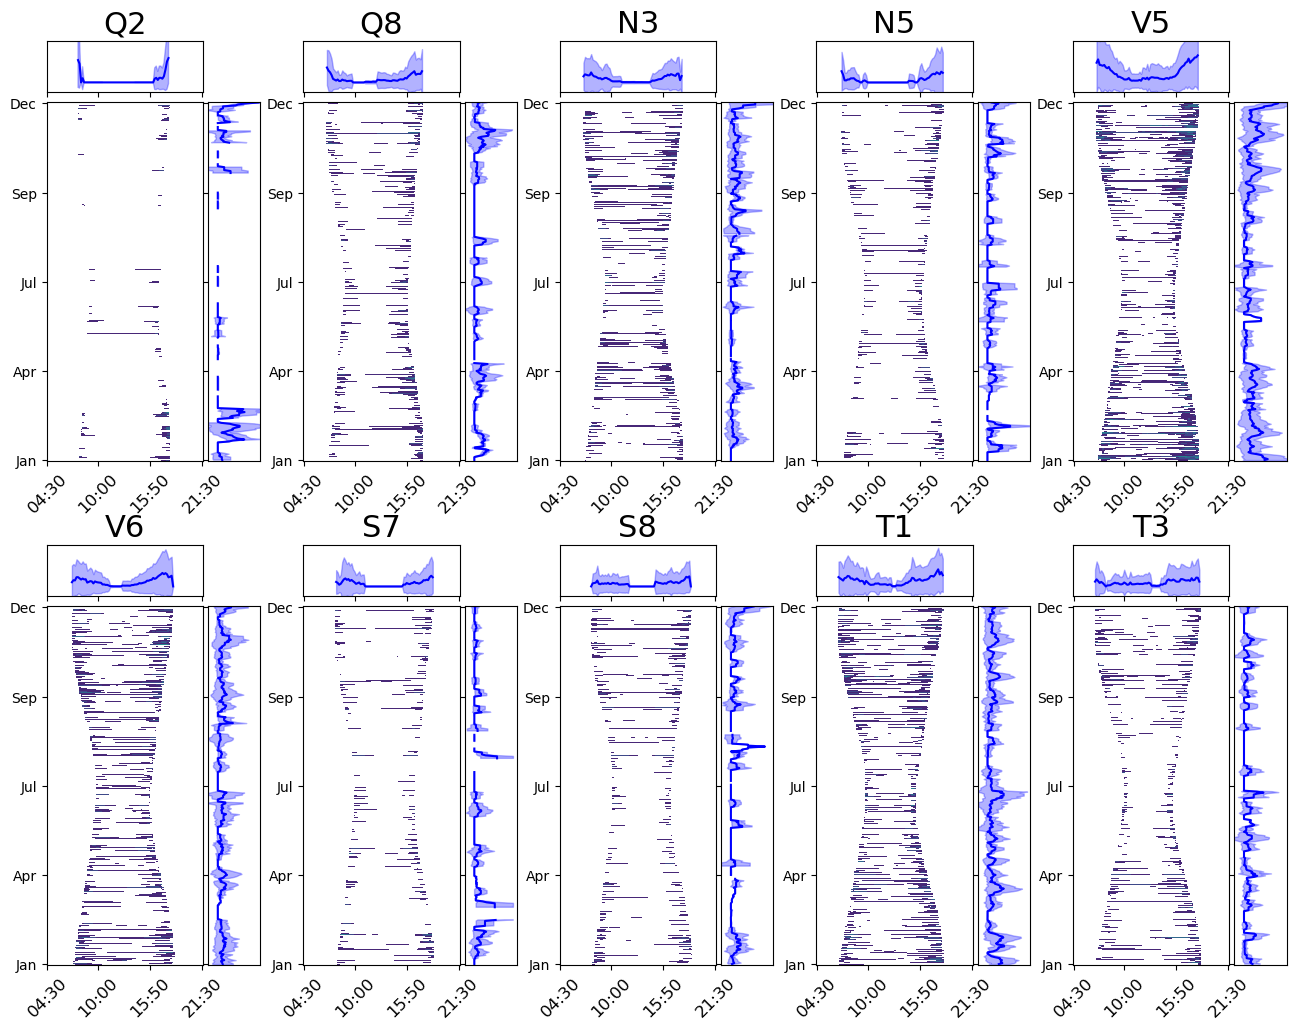

In [14]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0], sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1], sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.2, time=6)
    df = df.drop(df.columns[49], axis=1)
    df[df == 0] = np.nan

    # Heatmap
    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
    ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
    ax_heatmap.set_yticks(yticks)
    ax_heatmap.set_yticklabels(ytick_labels, fontsize=10)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    line1, = ax_top.plot(mean_daily.values, color="blue", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_ylim(0.08,0.25)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="blue", label='Mean (annual)')
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_xlim(0.08, 0.25)

fig.colorbar(im, cax=cbar_ax).set_label('Solar Irradiance (normalized)', fontsize=12)
plt.show()

# Day/Year Heatmap

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

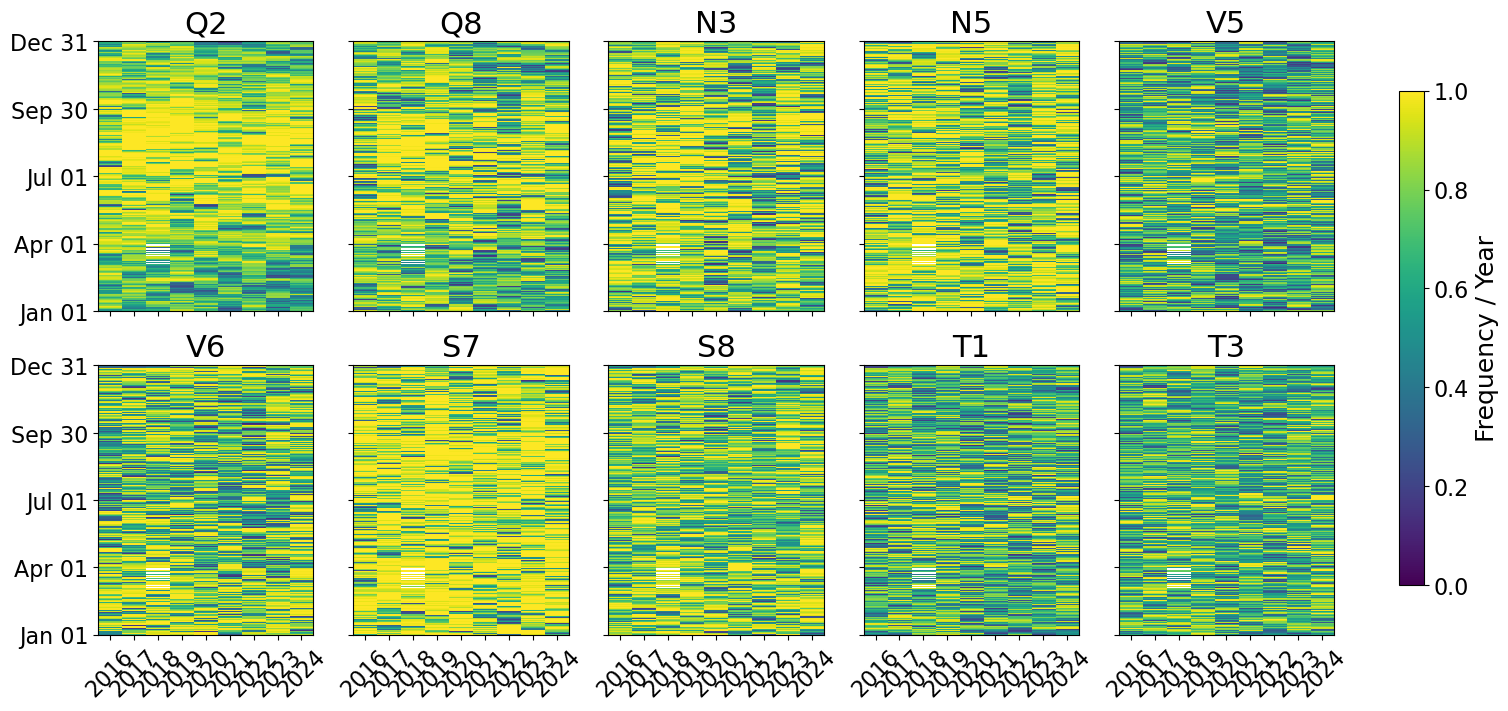

In [15]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
ax = ax.flatten()
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None
for i, reg in enumerate(regions):
    df = solar_plotting.day_year_df(daily[reg])

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')
    im = ax[i].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax[i].set_title(reg)
    xticks = np.arange(len(df.columns))
    xtick_labels = df.columns.astype(str)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    
    # Y-axis (Convert Day of Year → Month-Day)
    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
    ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
    ax[i].set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

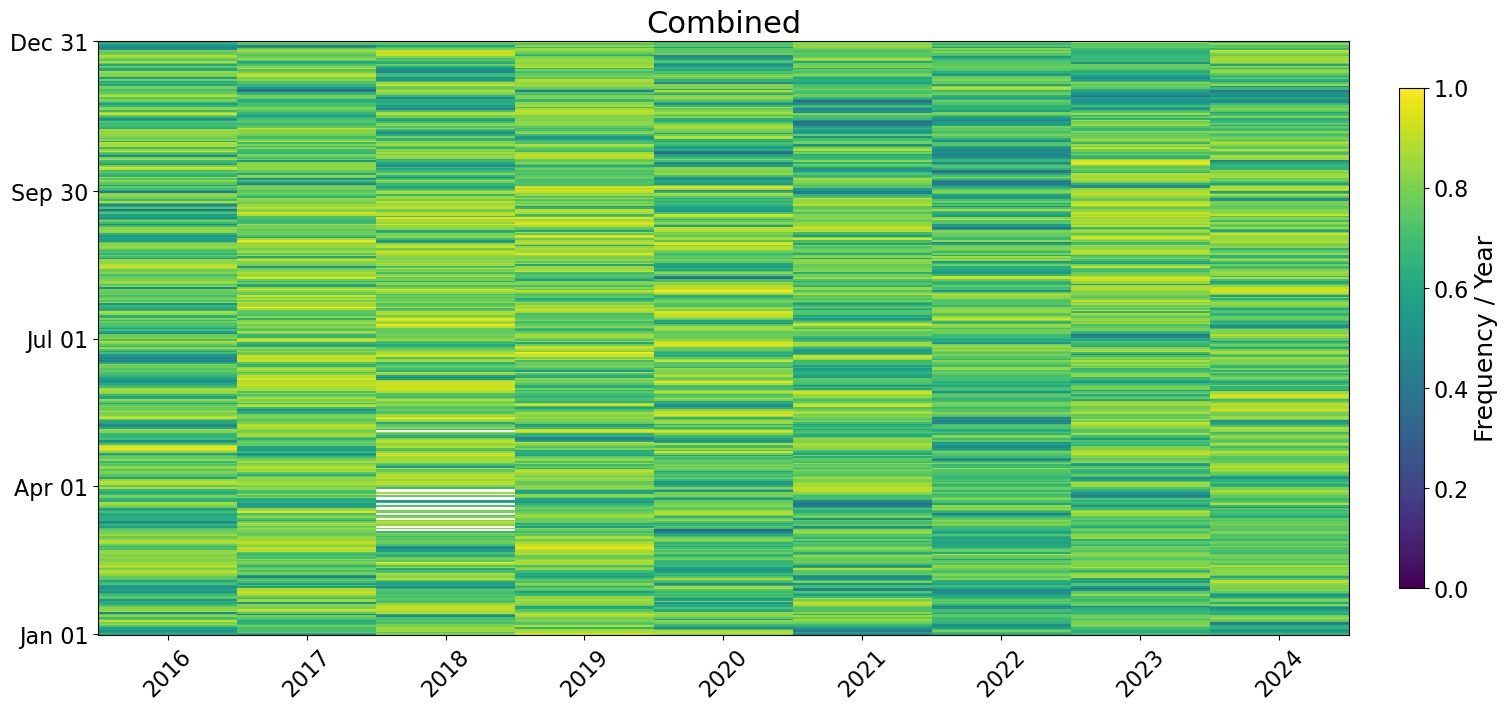

In [16]:
fig, ax = plt.subplots(figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

df = solar_plotting.day_year_df(daily.total)

cmap = plt.cm.viridis
cmap.set_bad(color='white')
im = ax.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
ax.set_title("Combined")
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

# Y-axis (Convert Day of Year → Month-Day)
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
ax.set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

# Coincident Droughts

In [17]:
coincident_droughts = np.zeros(len(ds_aus.time))
for reg in regions:
    drought_data = xr.where(ds_aus[reg] < 0.2, 1, 0).values
    coincident_droughts += drought_data
coincident_da = xr.DataArray(coincident_droughts, dims=ds_aus.dims, coords=ds_aus.coords)

daily = ds_aus.resample(time="1D").mean()
coincident_droughts_daily = np.zeros(len(daily.time))
for reg in regions:
    drought_data = xr.where(daily[reg] < 0.2, 1, 0).values
    coincident_droughts_daily += drought_data
coincident_da_daily = xr.DataArray(coincident_droughts_daily, dims=daily.dims, coords=daily.coords)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

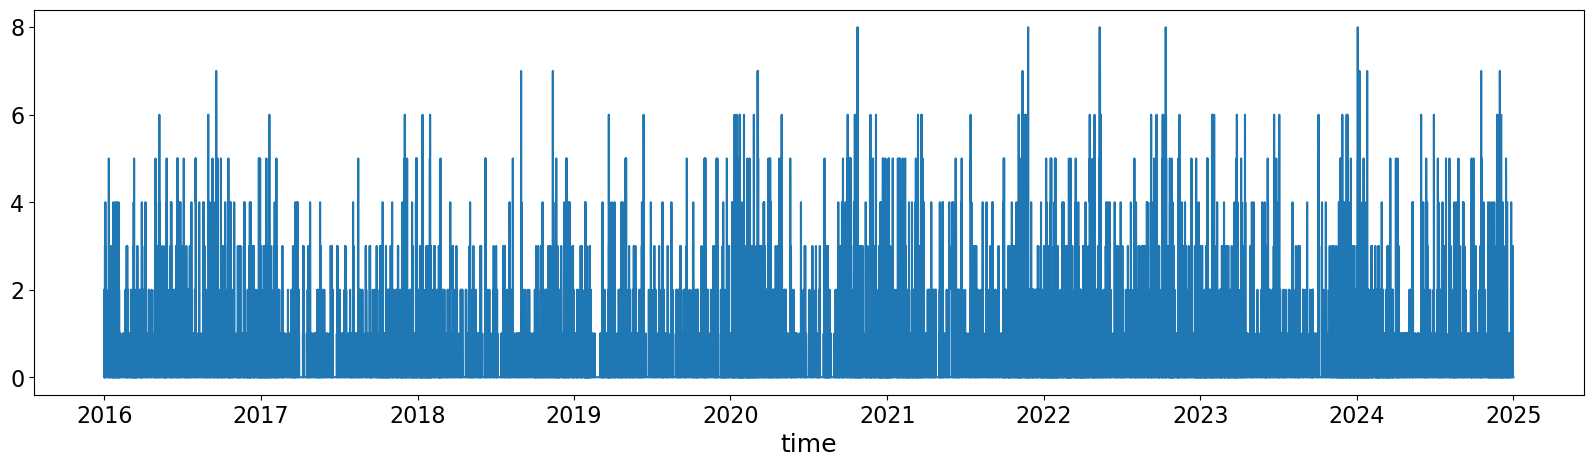

In [18]:
coincident_da.plot(figsize=(20,5))

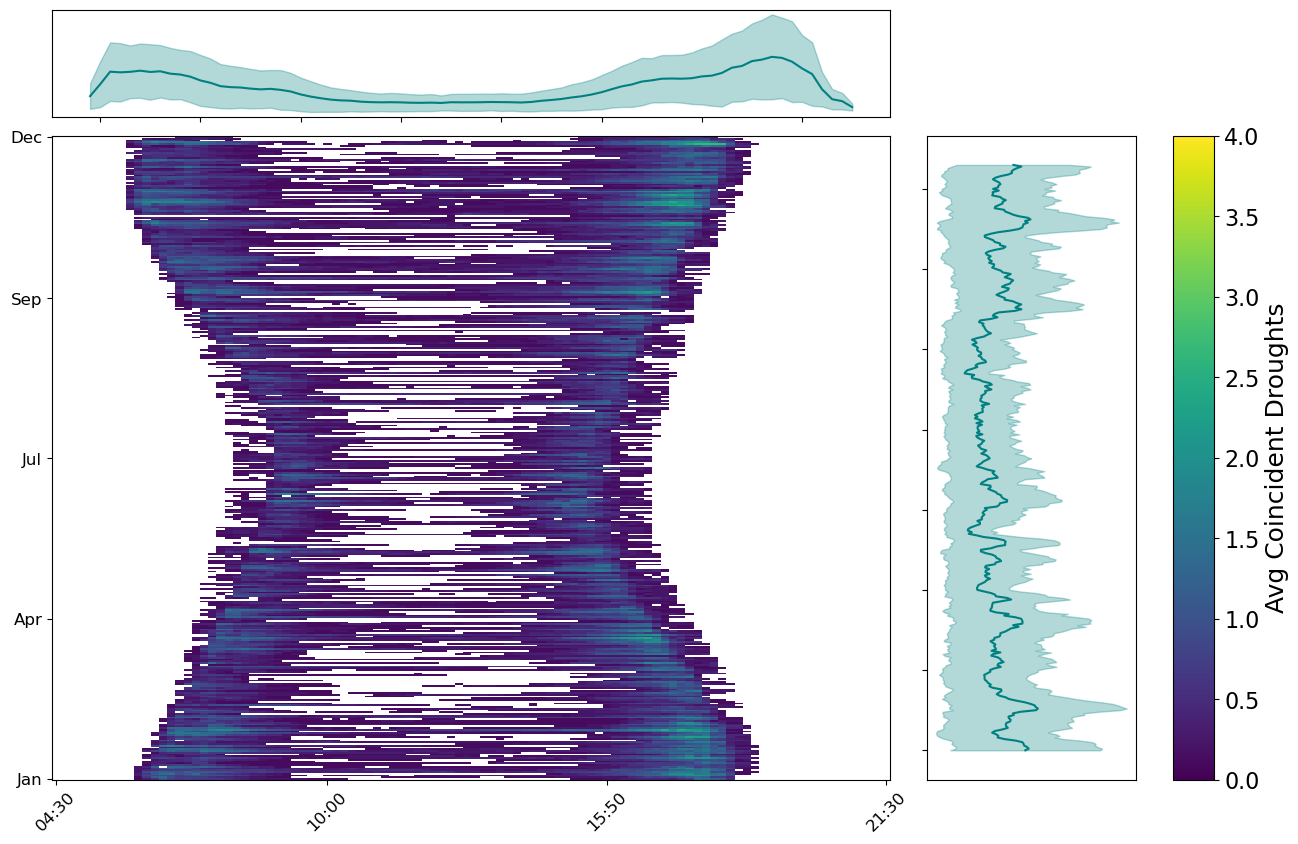

In [19]:
# Prepare data
df = solar_plotting.day_time_df(coincident_da)
df = df.drop(df.columns[49], axis=1)
df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# Axis ticks - x
xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

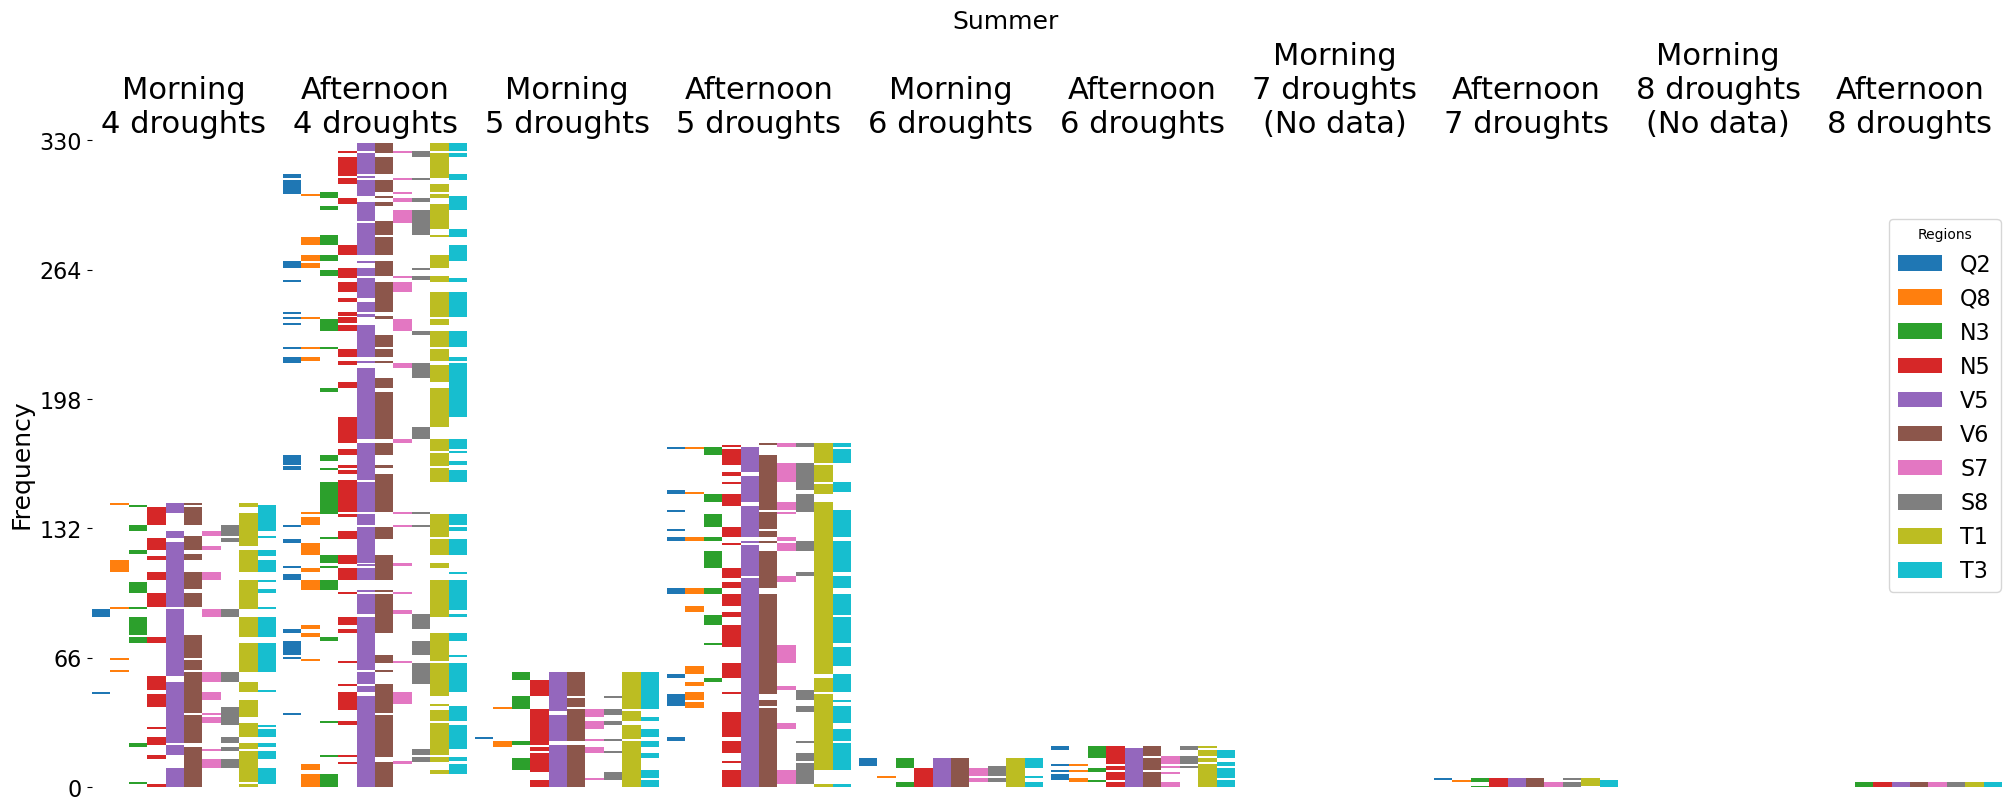

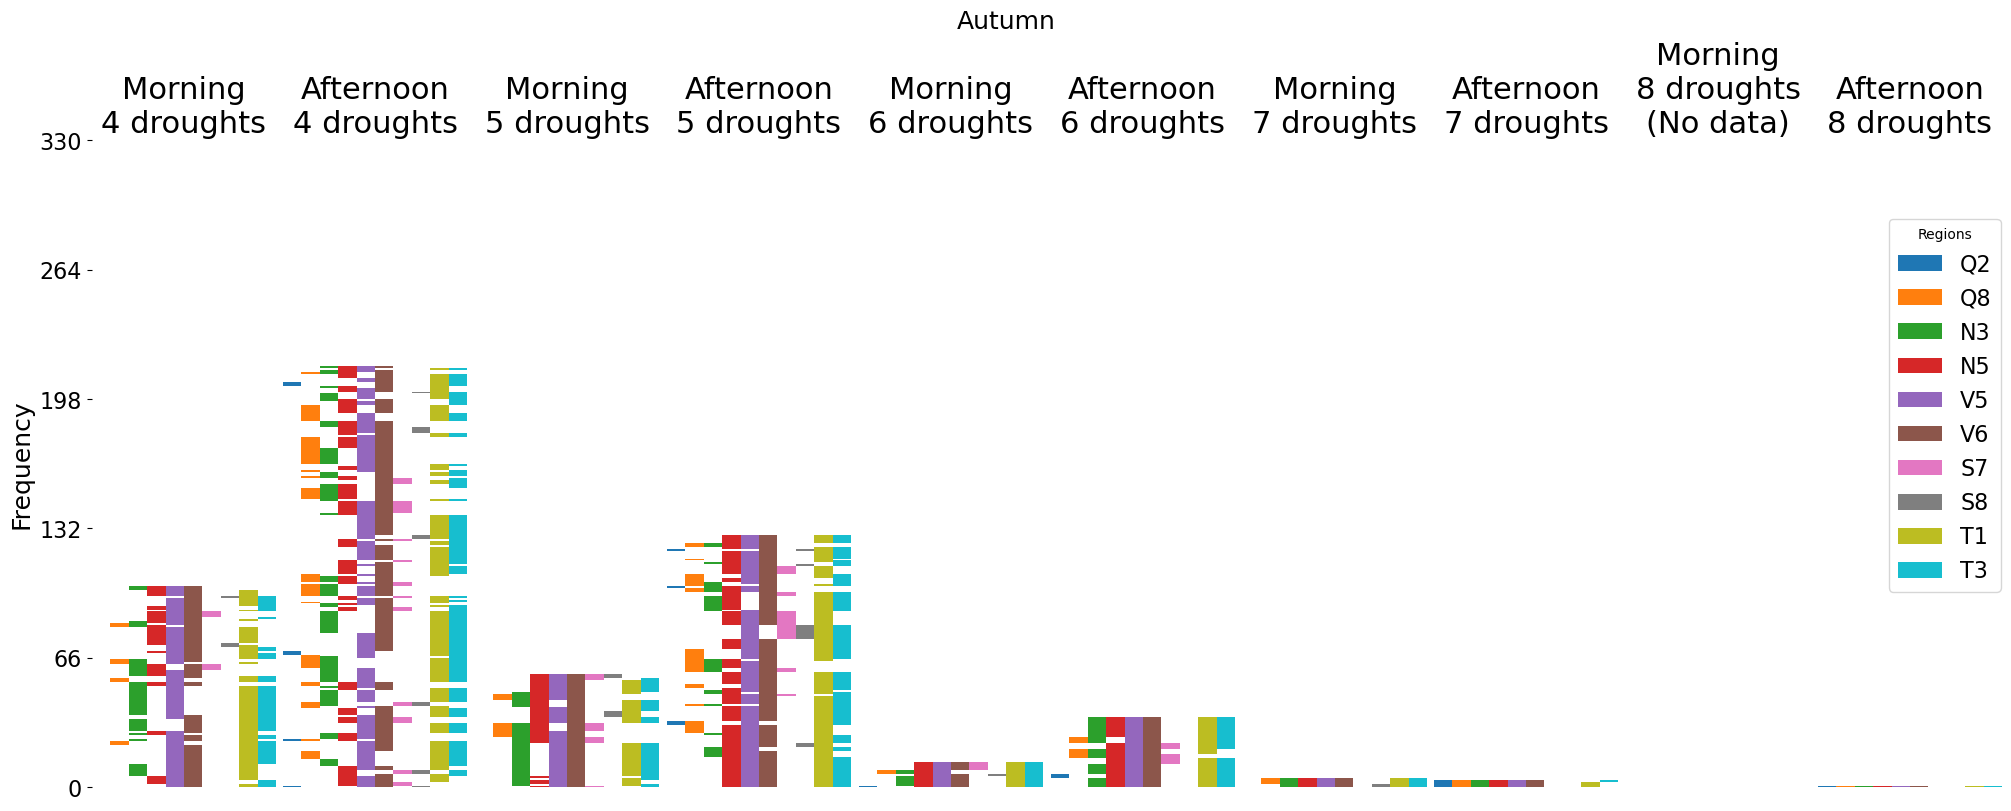

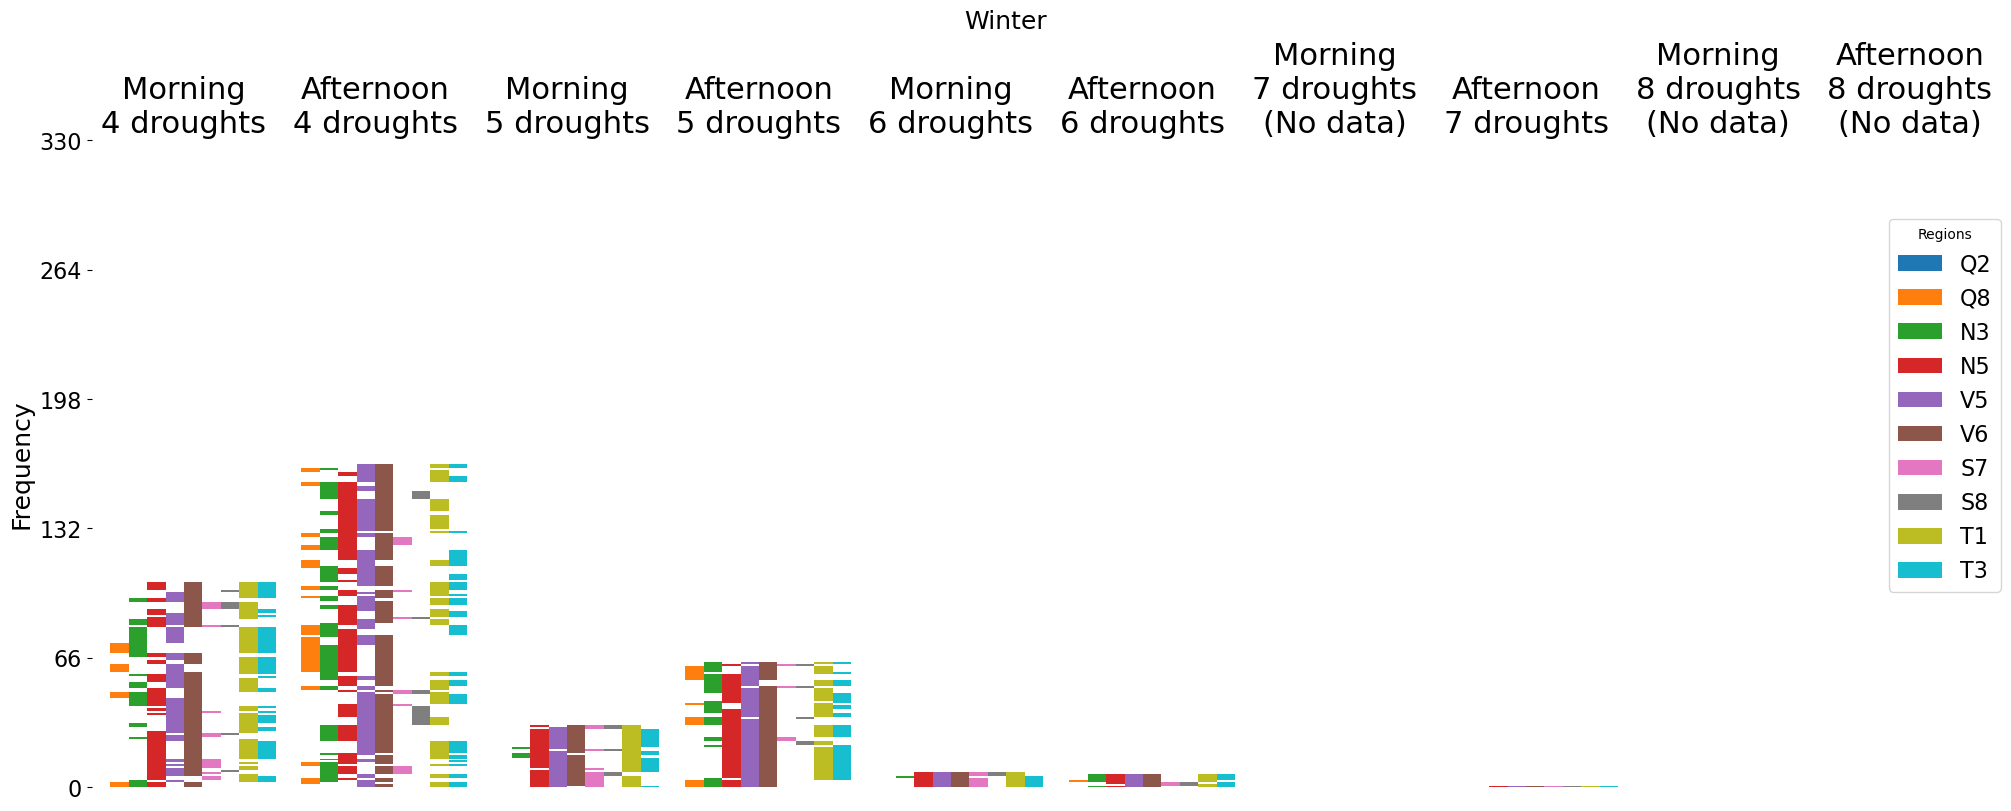

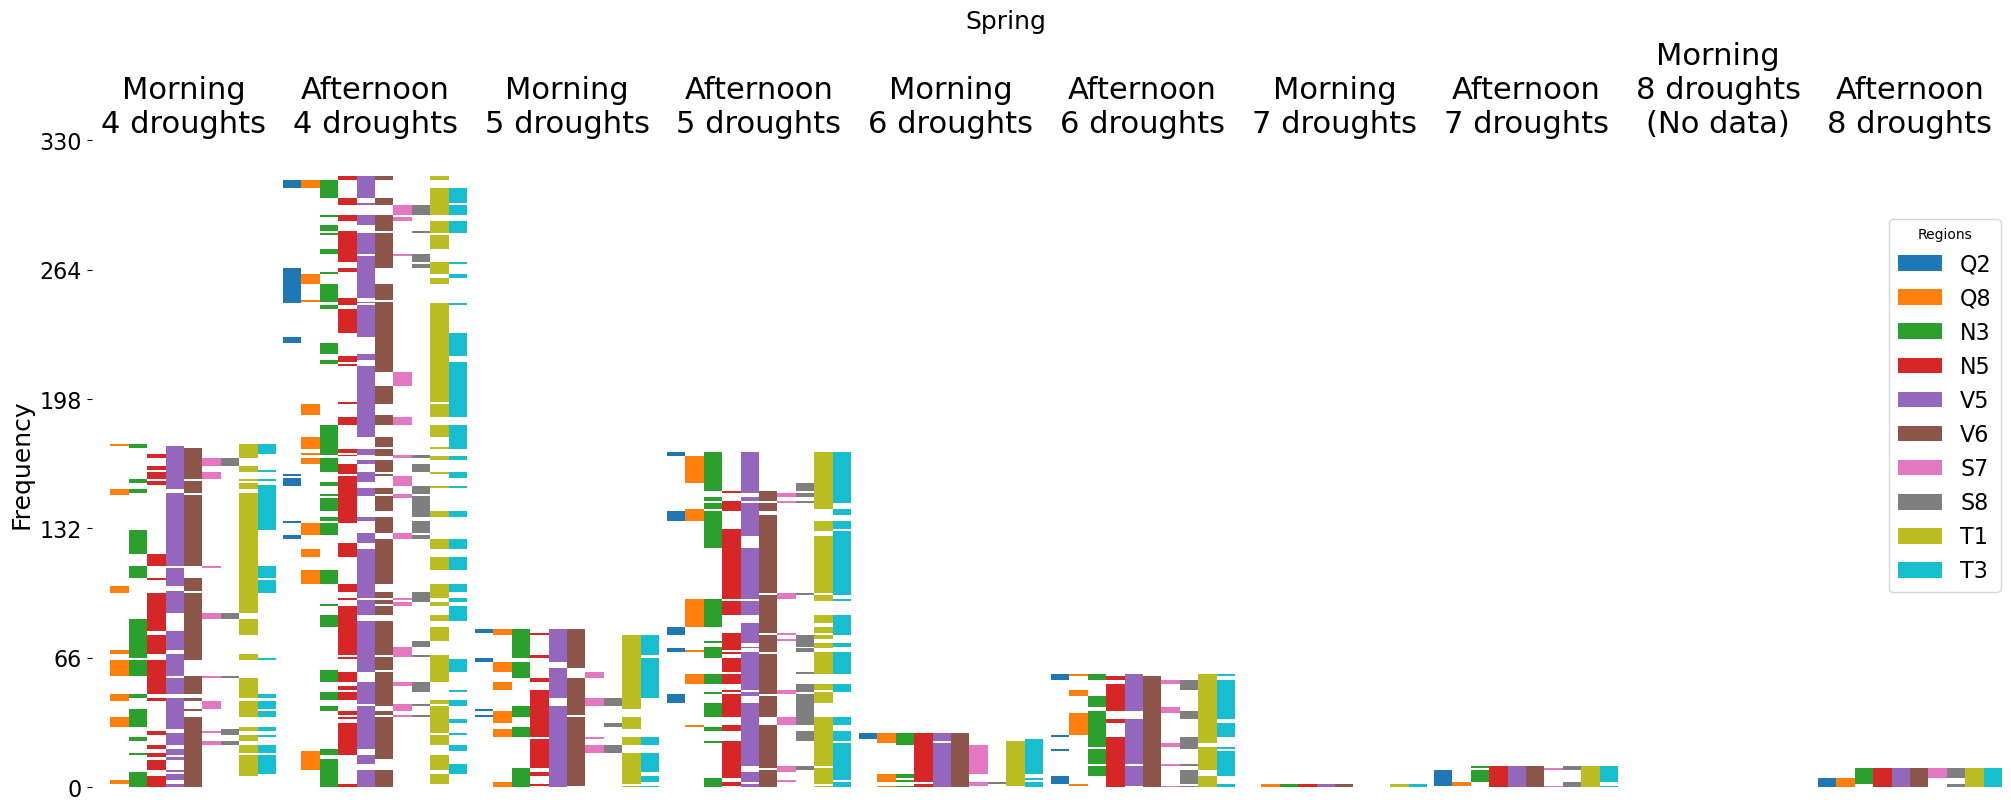

In [21]:
seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

for season in seasons:
    seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True)
    morning_data = seasonal_data.where(seasonal_data.time.dt.hour < 12, drop=True)
    afternoon_data = seasonal_data.where(seasonal_data.time.dt.hour >= 12, drop=True)

    fig, axes = plt.subplots(
        nrows=1, ncols=10, figsize=(20, 8),
        constrained_layout=True
    )

    all_regions = list(regions)  # ensure legend includes all
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_regions)))[:, :3]

    i = 0
    for num_droughts in range(4, 9):
        for tod_label, time_of_day in zip(["Morning", "Afternoon"], [morning_data, afternoon_data]):
            times = time_of_day[time_of_day == num_droughts].time.data

            if len(times) == 0:
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title(f"{tod_label}\n{num_droughts} droughts\n(No data)")
                for spine in axes[i].spines.values():
                    spine.set_visible(False)
                i += 1
                continue

            # Build DataFrame
            data = {
                reg: coincident_drought_ds[reg].sel(time=times).data.astype(int)
                for reg in all_regions
            }
            df = pd.DataFrame(data, index=times)

            rgb_img = np.ones((len(df), len(df.columns), 3))
            for j, col in enumerate(df.columns):
                rgb_img[df[col].values == 1, j, :] = colors[j]

            axes[i].imshow(rgb_img, aspect='auto', interpolation='none')
            axes[i].set_title(f"{tod_label}\n{num_droughts} droughts")
            axes[i].set_xticks([])
            axes[i].set_xticklabels([])
            axes[i].set_yticks([])
            axes[0].set_yticks(np.linspace(0, 330, 6, dtype=int))
            axes[0].set_ylabel("Frequency")
            axes[i].set_ylim(0, 330)
            for spine in axes[i].spines.values():
                spine.set_visible(False)

            i += 1

    # Legend
    legend_elements = [Patch(facecolor=colors[j], label=reg) for j, reg in enumerate(all_regions)]
    fig.legend(handles=legend_elements, loc='center right', title='Regions')

    fig.suptitle(f"{season.capitalize()}", fontsize=18)
    plt.show()

In [45]:
def regional_correlations(ds):
    # Stack each variable into a new 'variable' dimension
    data = xr.concat(
        [ds[var].expand_dims(variable=[var]) for var in ds.data_vars],
        dim='variable'
    )
    data = data.dropna(dim='time', how='any')
    data = data.transpose('variable', 'time')  # shape: (variable, time)
    
    # Compute pairwise correlations
    var_names = data['variable'].values
    n = len(var_names)

    corr = np.empty((n, n), dtype=np.float64)

    for i in range(n):
        for j in range(n):
            corr[i, j] = xr.corr(data.sel(variable=var_names[i]),
                                 data.sel(variable=var_names[j]),
                                 dim='time').item()

    return pd.DataFrame(corr, index=var_names, columns=var_names)

In [46]:
corr_df = regional_correlations(ds).iloc[:-1,:-1]

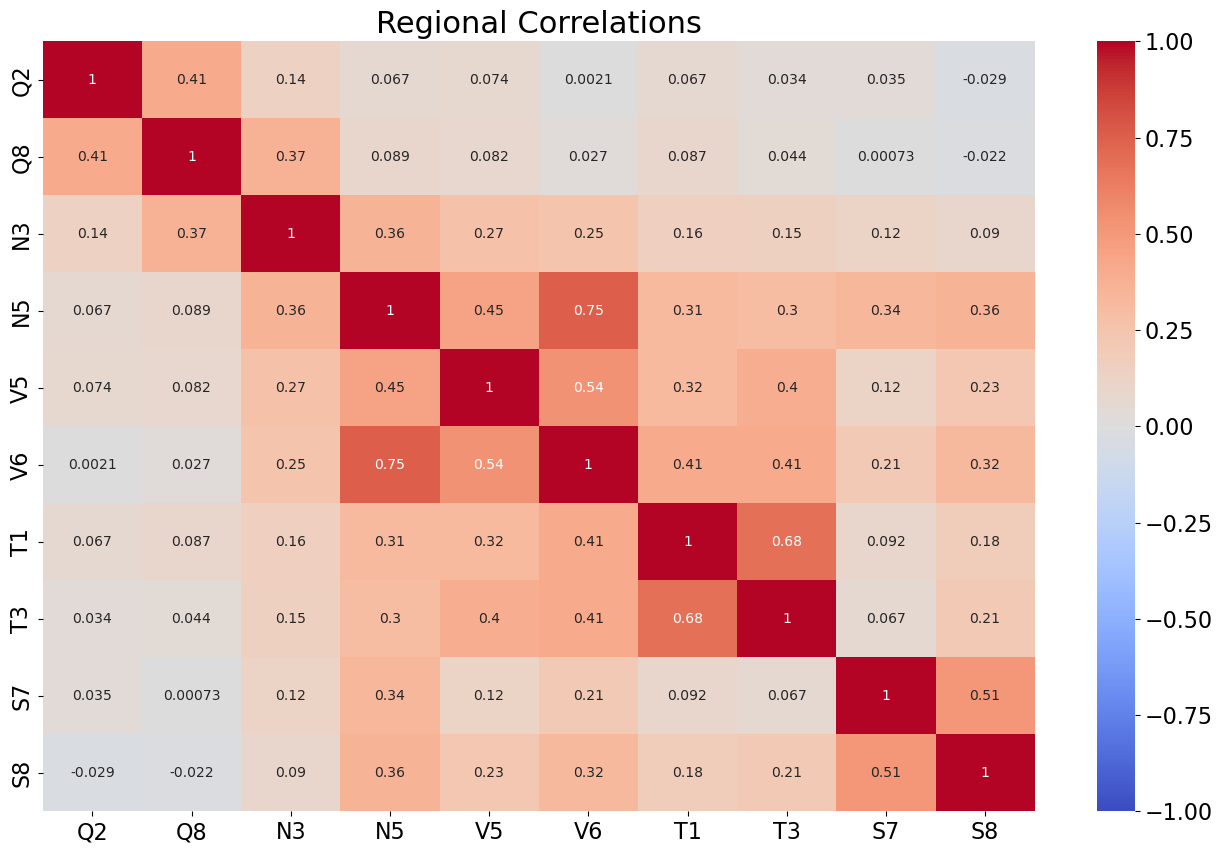

In [47]:
plt.figure(figsize=(16,10))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Regional Correlations')
plt.show()

In [48]:
coincident_dict = {}
for reg in regions:
    coincident_dict[reg] = []
    for second_reg in regions:
        total = sum(xr.where(ds[reg] < 0.2, 1, 0).data)
        coincident = sum(xr.where((ds[reg] < 0.2) & (ds[second_reg] < 0.2), 1, 0).data)
        coincident_dict[reg].append(coincident/total)
coincident_df = pd.DataFrame(coincident_dict, index=coincident_dict.keys())

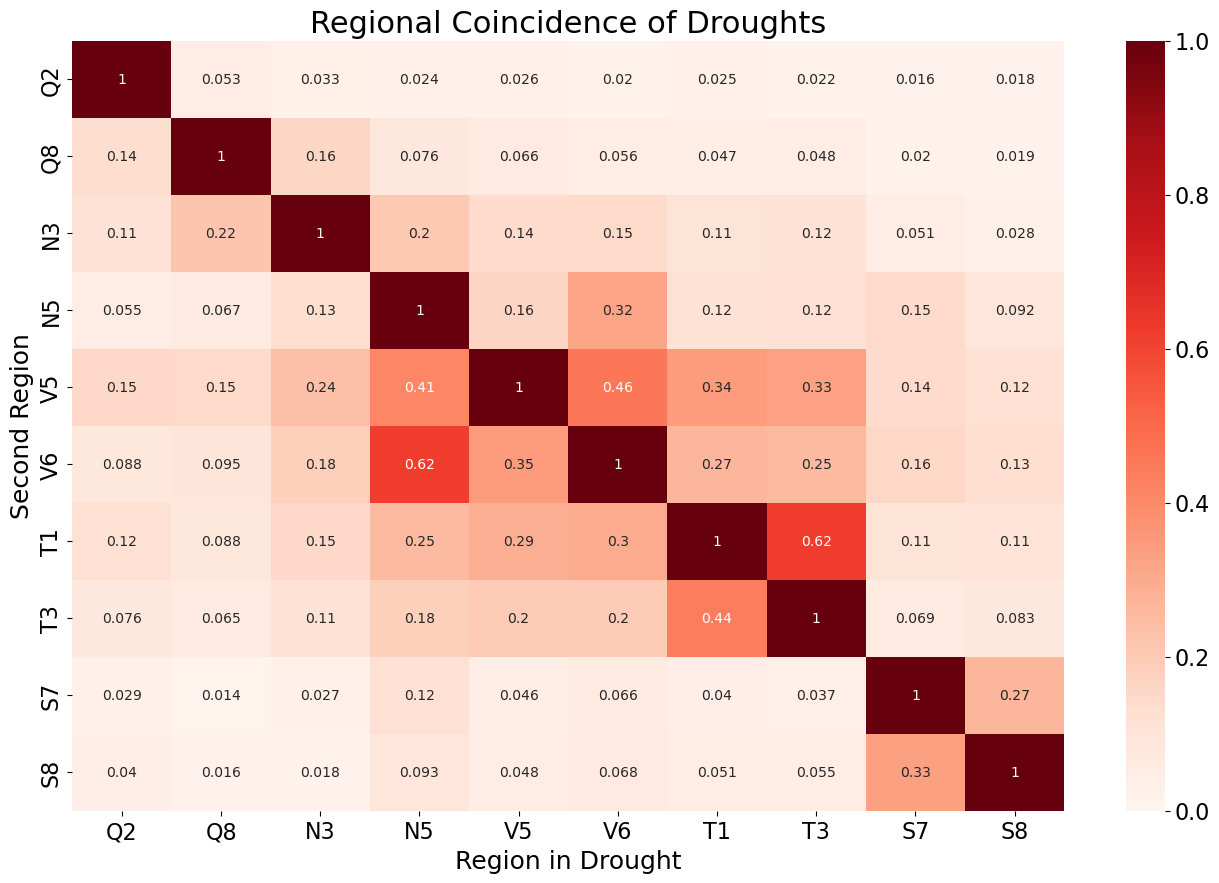

In [49]:
plt.figure(figsize=(16,10))
sns.heatmap(coincident_df, annot=True, cmap='Reds', vmin=0, vmax=1)
plt.title('Regional Coincidence of Droughts')
plt.xlabel('Region in Drought')
plt.ylabel('Second Region')
plt.show()

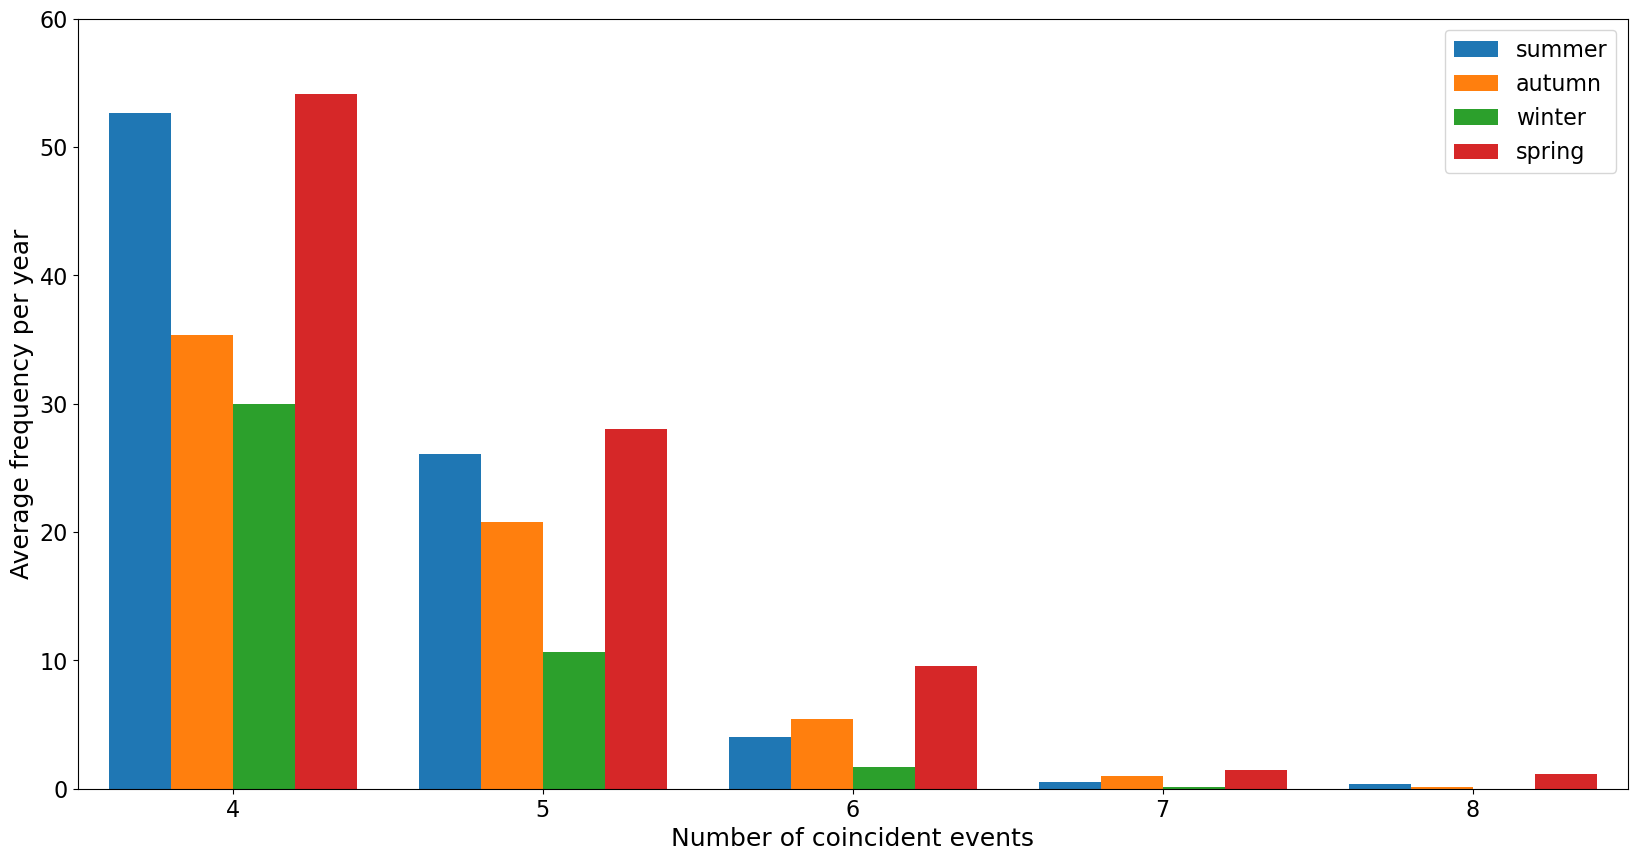

In [22]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.2
season_names = list(seasons.keys())
season_offsets = np.arange(-1.5, 2) * bar_width  # for 4 seasons

for i, season in enumerate(season_names):
    data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True).values
    num, freq = np.unique(data.data, return_counts=True)

    # Remove zero entry
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_da.time.dt.year))

    # Shift bar positions
    x_pos = num + season_offsets[i]
    ax.bar(x_pos, freq, width=bar_width, label=season)

ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 60)
ax.set_xlabel("Number of coincident events")
ax.set_ylabel("Average frequency per year")
ax.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


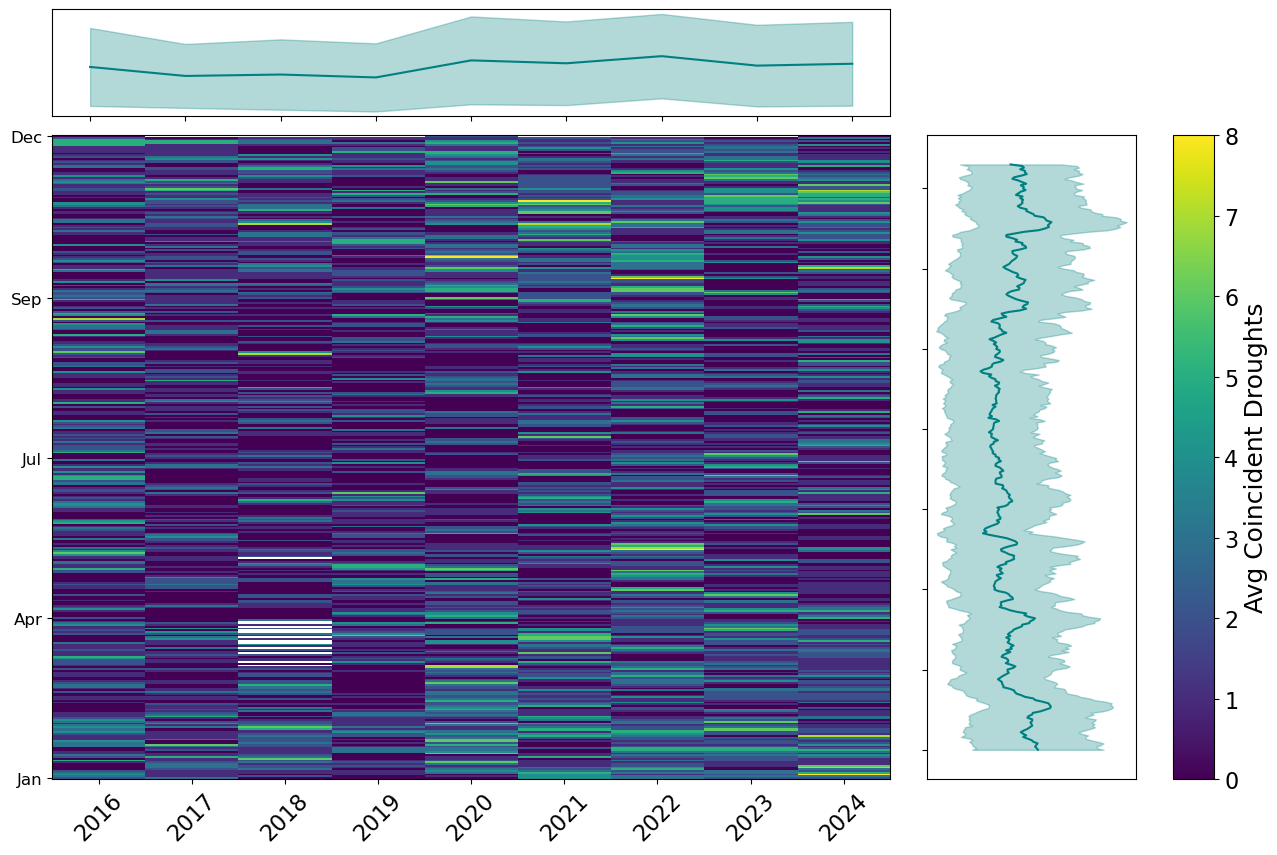

In [23]:
# Prepare data
# Prepare data
coincident_daily = coincident_da.resample(time="1D").max()
df = solar_plotting.day_year_df(coincident_daily)
# df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=8, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# X-axis: years
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

In [25]:
coincident_drought_matrix

NameError: name 'coincident_drought_matrix' is not defined

In [ ]:
# Example boolean matrix: True where values are below the threshold
threshold = 0.2
coincident_drought_ds = ds_aus < threshold

# Convert to 2D for plotting: variable x time
coincident_drought_matrix = xr.concat([coincident_drought_ds[var] for var in ds_aus.data_vars], dim="variable")
coincident_drought_matrix["variable"] = list(ds_aus.data_vars)

In [ ]:
df = coincident_drought_matrix.transpose("time", "variable").to_pandas().astype(int)
df = df.drop(columns='total')

In [ ]:
df_cut = df.iloc[200:400,:]

# Stacked area plot directly (no cumulative sum needed)
df_cut.plot.area(figsize=(12, 6), cmap="tab10")
plt.title("Which series are below threshold over time")
plt.xlabel("Time")
plt.ylabel("Below-threshold indicator (stacked)")
plt.legend(title="Series", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
plt.xlim(0,1000)

# Worst Events

In [ ]:
threshold = 0.35
data = ds_aus.total.dropna(dim='time').rolling(time=100).mean()
events = xr.where(data < threshold, data, np.nan).dropna(dim='time')
np.unique(events.time.to_index().date)

In [ ]:
ds_aus.total.dropna(dim='time').rolling(time=100).mean().plot()
plt.axhline(threshold, color='r', linestyle = '--')

# Spectral Analysis

In [ ]:
def spectral_fft(da, time_res=False, clim=False, window=False):
    if time_res:
        da = da.resample(time=time_res).mean()
    if window:
        da = da.rolling(time=window, center=True, min_periods=1).mean()
    if clim:
        climatology = da.groupby("time.dayofyear").mean("time")
        da = da.groupby("time.dayofyear") - climatology
    clean = da.dropna(dim="time")
    data = (clean - clean.mean(dim='time')).values

    N = len(data)
    fft_vals = np.fft.fft(data)
    freqs = np.fft.fftfreq(N, d=1)
    
    positive = freqs > 0
    freqs_pos = freqs[positive]
    power = np.abs(fft_vals[positive])**2 / N**2

    # Normalize to match variance via Parseval
    delta_f = freqs_pos[1] - freqs_pos[0]
    power *= np.var(data) / (np.sum(power) * delta_f)

    periods = 1 / freqs_pos
    return periods, power

In [ ]:
time_res = False
clim = True
window=700

fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(16,16), sharex=True)

for i, reg in enumerate(regions):

    fft_periods, fft_power = spectral_fft(da=ds_aus[reg], time_res=time_res, clim=clim, window=window)
    # welch_periods, welch_power = solar_plotting.spectral_welch(da=ds_aus[reg], nperseg=2048, time_res=time_res, clim=clim)
    # mt_periods, mt_power = solar_plotting.spectral_multitaper(da=ds_aus[reg], NW=2.5, k=4, time_res=time_res, clim=clim)
    # mt_mask = mt_periods >= np.min(fft_periods)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    # ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    # ax[i].semilogx(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', linestyle = ':')
    ax[i].set_ylabel(reg, rotation=0, labelpad=30)
    # ax[i].set_xlim(1,100)
    # ax[i].set_ylim(0,20)
    
    fig.gca().invert_xaxis()
ax[0].legend()
plt.xlim(window)
plt.tight_layout()

In [ ]:
# Wavelet

for reg in regions:
    # daily = ds_aus[var].resample(time="1D").mean()
    clean = ds_aus[reg].dropna(dim="time")
    data = clean - clean.mean(dim="time")
    signal = data.values
    
    scales = np.arange(1, 100)
    coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='morl', sampling_period=1)
    
    # Compute power and apply log scale (add small constant to avoid log(0))
    power = np.abs(coefficients) ** 2
    log_power = np.log2(power + 1e-8)
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(power,
                    extent=[0, len(signal), scales[-1], scales[0]], #vmax = 3,
                    aspect='auto', cmap='RdYlBu_r')
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(im)
    cbar.set_label("Power")
    
    plt.xlabel("Time (samples since start)")
    plt.ylabel("Period (number of samples)")
    plt.title(reg)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()